In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sig
import seaborn as sns
import scipy.io
import math

## 1- From stimulus to neuronal activity (PSTH)

In [136]:
num_trials = 500
num_seconds = 100
sampling_rate = 1000
range_of_uniform_distribution = np.arange(100,90000)


In [137]:
data1 = pd.read_csv('psthData1.csv',header=None)
data2 = pd.read_csv('psthData2.csv', header=None)
stimulus = pd.read_csv('psthStimOnsets.csv', header=None)
neuron1 = data1.to_numpy()
neuron2 = data2.to_numpy()
stimuli_time = stimulus.to_numpy()


In [5]:
print(neuron1.shape)
print(neuron2.shape)
print(stimuli_time.shape)


(100000, 500)
(100000, 500)
(500, 1)


In [6]:

# duration I want to look at is 200ms
# for each trial I will take the 50ms before the stimulus, 150ms after
# bins I will look at is 1ms, so in total I will get 200 bins
# cutting the the trials to align the same onsets

'''
This function get a trial and a time of stimuli and cut the relevant time according to my definitions.
'''
def align_trials(neural_activity, stimuli_time, num_trials):
    aligned_trial = []
    
    for i, stim in enumerate(stimuli_time):
        stim = int(stim)
        temp_trial = neural_activity[stim-50:stim+150, i]
        num_of_spike = np.sum(temp_trial)
        temp_trial = temp_trial*(1000/num_of_spike)
        temp_trial = temp_trial.tolist()
        aligned_trial.append(temp_trial)
                
    return aligned_trial

In [7]:
def plot_pstf_and_raster(activity_mat, name):
    fig, ax = plt.subplots(nrows=2,ncols=1, figsize=[10,9])

    for trial in range(num_trials):
        spike_times = [i for i, x in enumerate(activity_mat[trial]) if x != 0]
        ax[0].vlines(spike_times, trial - 0.5, trial + 0.5)

    # Set x axis range so that time zero is more visible    
    ax[0].set_xlim([-10, len(activity_mat[0][:])+10])

    # specify tick marks and label label y axis
    ax[0].set_ylabel('Trial Number')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_title('Neuronal Spike Times') 
    ax[0].vlines(50,0,500,color='red')
    
    # Draw the PSTH
    ax[1].bar(range(200),np.sum(activity_mat,0),2)
    
    # Use same x axis limits as for raster plot
    ax[1].set_xlim([-10, len(activity_mat[0][:])+10])
    ax[1].set_title('Peri-Stimulus Time Histogram (PSTH)')
    ax[1].set_xlabel('Time (ms)')
    ax[1].set_ylabel('Count of spike')
    ax[1].vlines(50,0,np.max(np.sum(activity_mat,0)),color='red')
    
    fig.suptitle(name)


#### 1-A: PSTH and Raster plots

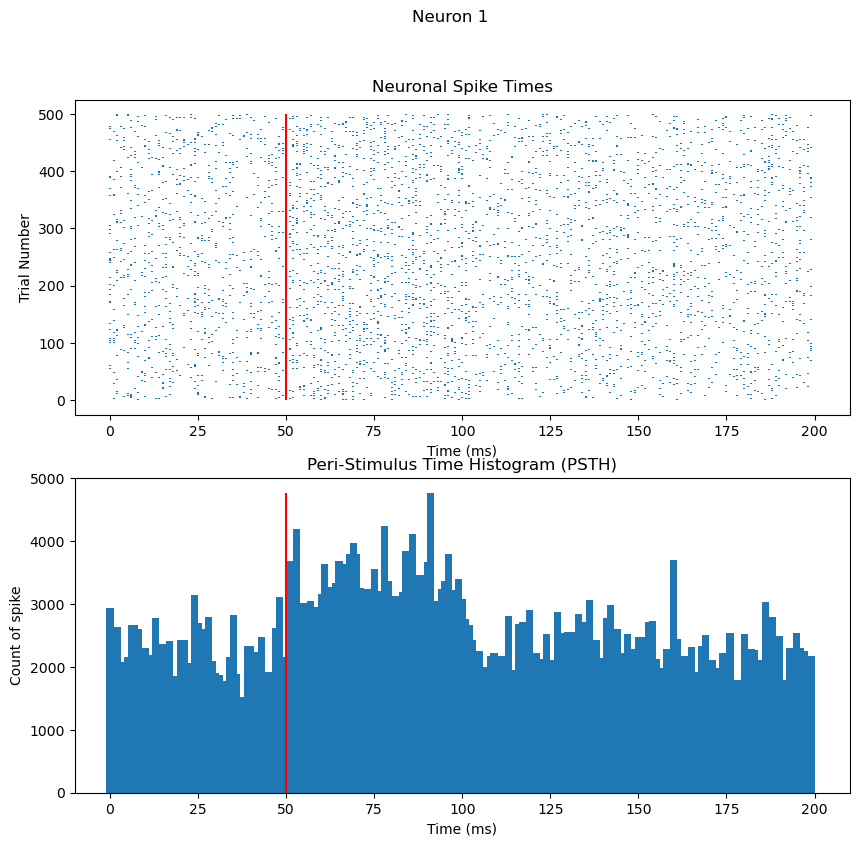

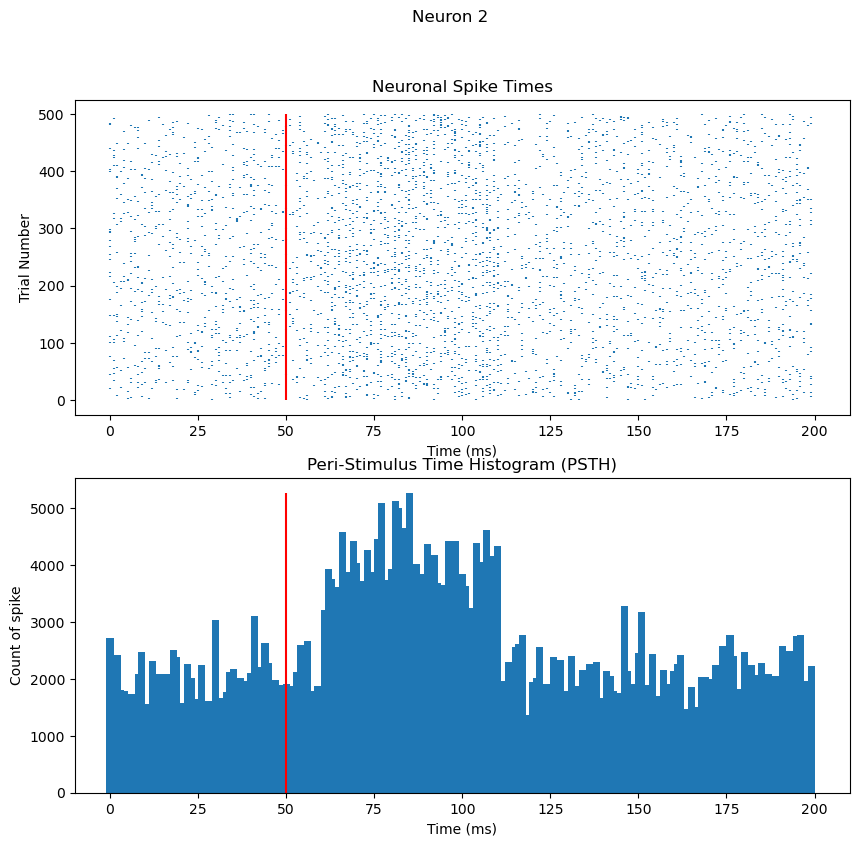

In [8]:
mat1 = align_trials(neuron1, stimuli_time, num_trials)
arr_mat1 = np.array(mat1)
plot_pstf_and_raster(arr_mat1,'Neuron 1')

mat2 = align_trials(neuron2, stimuli_time, num_trials)
arr_mat2 = np.array(mat2)
plot_pstf_and_raster(arr_mat2,'Neuron 2')


#### 1-B: JPSTH

In [9]:
# I want to create an initial matrix of size 800X800 the duration I have chsen
# each trial I need to over the two neurons in parallerl to see the indexes both fire together
# adding 1 to the initial matrix to the correct indexes 
'''
This function get two neuron activities and calculate the joint spikes in a matrix.
It returns a matrix of JPSTH
'''
def create_jpsth_mat(neuron1, neuron2, duration):
    
    jpsth_mat = np.zeros((duration,duration))
    indexes = []
    
    # looking for all indexes where both neurons fire
    for trial in range(num_trials):
        for i, x in enumerate(neuron1[trial,:]):
            for j, y in enumerate(neuron2[trial,:]):
                if x != 0 and y != 0:
                    indexes.append((i,j))
    
    for ind in indexes:
        jpsth_mat[ind[0],ind[1]] += 1
    
    jpsth_mat = jpsth_mat / num_trials
    return jpsth_mat

Text(0.5, 1.0, 'JPSTH')

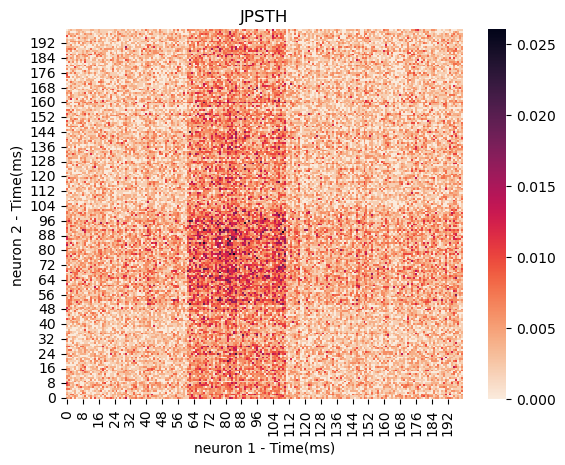

In [10]:
# call create_jpsth_mat and plot it 
jpsth = create_jpsth_mat(arr_mat1,arr_mat2,len(arr_mat1[0]))
fig,ax = plt.subplots()
ax = sns.heatmap(jpsth, cmap="rocket_r")
ax.invert_yaxis()
ax.set_xlabel('neuron 1 - Time(ms)')
ax.set_ylabel('neuron 2 - Time(ms)')
ax.set_title('JPSTH')

In [11]:
'''
This function get two neuron activities and duration and calculate the joint spikes in a matrix.
But it also do Shift predictor by looking at trial n with trial n+1 in the other neuron.
It returns a matrix of JPSTH
'''
def create_jpsth_shift_mat(neuron1, neuron2, duration):
    
    jpsth_mat = np.zeros((duration,duration))
    indexes = []
#     neuron2 = np.random.shuffle(neuron2)
    # looking for all indexes where both neurons fire
    for trial in range(num_trials):
        if trial == num_trials-1:
            for i, x in enumerate(neuron1[trial,:]):
                for j, y in enumerate(neuron2[0,:]):
                    if x != 0 and y != 0:
                        indexes.append((i,j))
            break
        for i, x in enumerate(neuron1[trial,:]):
            for j, y in enumerate(neuron2[trial+1,:]):
                if x != 0 and y != 0:
                    indexes.append((i,j))
    
    for ind in indexes:
        jpsth_mat[ind[0],ind[1]] += 1
    
    jpsth_mat = jpsth_mat / num_trials
    return jpsth_mat

Text(0.5, 1.0, 'JPSTH with shift predictor')

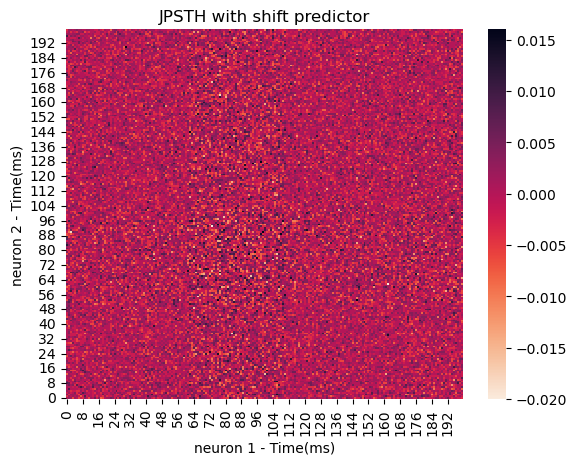

In [12]:
# call create_jpsth_shift_mat and plot 
jpsth_shift_predictor = create_jpsth_shift_mat(arr_mat1,arr_mat2,len(arr_mat1[0]))
fig,ax = plt.subplots()
ax = sns.heatmap((jpsth - jpsth_shift_predictor), cmap="rocket_r")
ax.invert_yaxis()
ax.set_xlabel('neuron 1 - Time(ms)')
ax.set_ylabel('neuron 2 - Time(ms)')
ax.set_title('JPSTH with shift predictor')

In [13]:
# create the shuffle for the reduction of the stimulation onset shuffle
# I will shuffle between the order of the stimuli time and call the function align_trials with it
stimuli_time_shuffle = np.copy(stimuli_time)
np.random.shuffle(stimuli_time_shuffle)

mat1_shuffle_stim = align_trials(neuron1, stimuli_time_shuffle, num_trials)
arr_mat1_shuffle_stim = np.array(mat1_shuffle_stim)

mat2_shuffle_stim = align_trials(neuron2, stimuli_time_shuffle, num_trials)
arr_mat2_shuffle_stim = np.array(mat2_shuffle_stim)

Text(0.5, 1.0, 'JPSTH with stimulus onset shuffle')

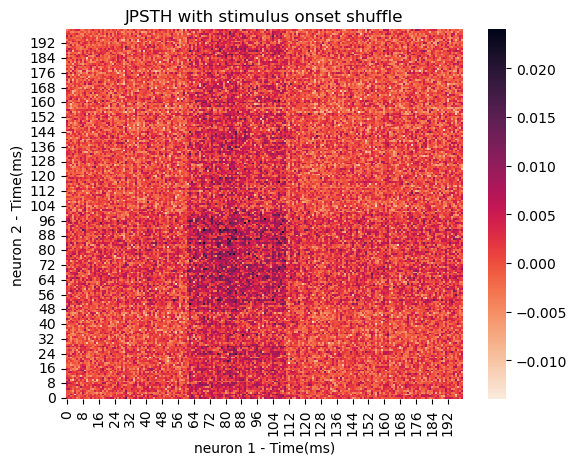

In [14]:
# call create_jpsth_mat and plot it 
jpsth_shuffle_stim = create_jpsth_mat(arr_mat1_shuffle_stim,arr_mat2_shuffle_stim,len(arr_mat1_shuffle_stim[0]))
fig,ax = plt.subplots()
ax = sns.heatmap(jpsth-jpsth_shuffle_stim, cmap="rocket_r")
ax.invert_yaxis()
ax.set_xlabel('neuron 1 - Time(ms)')
ax.set_ylabel('neuron 2 - Time(ms)')
ax.set_title('JPSTH with stimulus onset shuffle')

#### Using the Prague's measurement in this data also, just to try ;)

In [15]:
'''
This function gets an array and find according to a bin size a max fire rate and its index of start
'''
def find_max_fire(arr):
    bin_size = 8
    index = 0
    max_fire = 0
    max_fire_index = 0
    list_of_all_rates = []

    while index < 150:
        temp_max = np.mean(arr[index:index+bin_size])
        list_of_all_rates.append(temp_max)
        if temp_max > max_fire:
            max_fire = temp_max
            max_fire_index = index
        index += 1
    return (max_fire, max_fire_index, list_of_all_rates)

In [16]:
'''
This function gets an array and find according to a bin size a min fire rate and its index of start
'''
def find_min_fire(arr, num_indexes_to_reduce):
    bin_size = 8
    index = 0
    min_fire = 100000000
    min_fire_index = 0
    while index < 150-num_indexes_to_reduce:
        temp_min = np.mean(arr[index:index+bin_size])
        if temp_min < min_fire:
            min_fire = temp_min
            min_fire_index = index
        index += 1
    return (min_fire, min_fire_index)

/var/folders/zx/4crzfjcj5z1bc5krk4ps21lh0000gq/T/ipykernel_58284/847129829.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(figsize=(10,3))


269
424


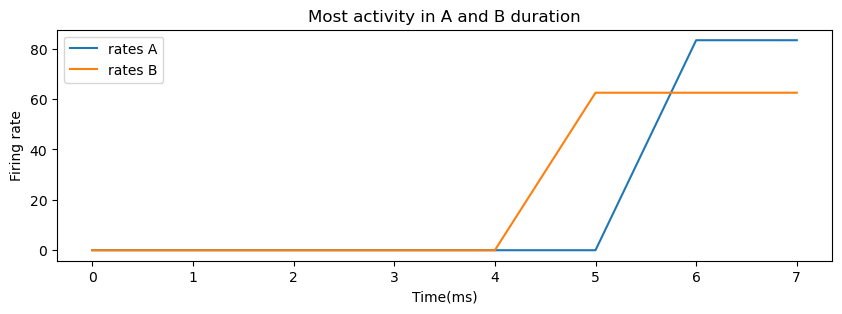

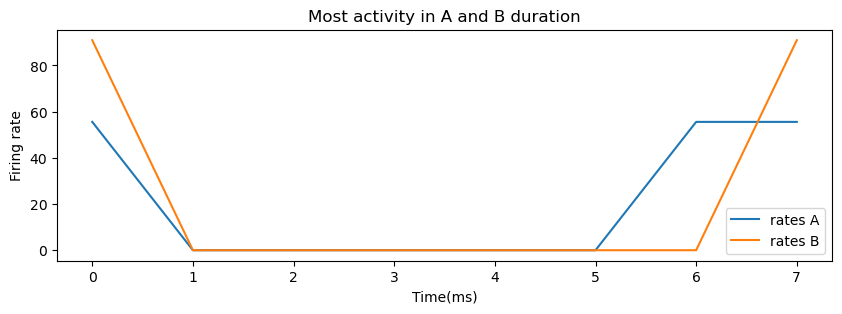

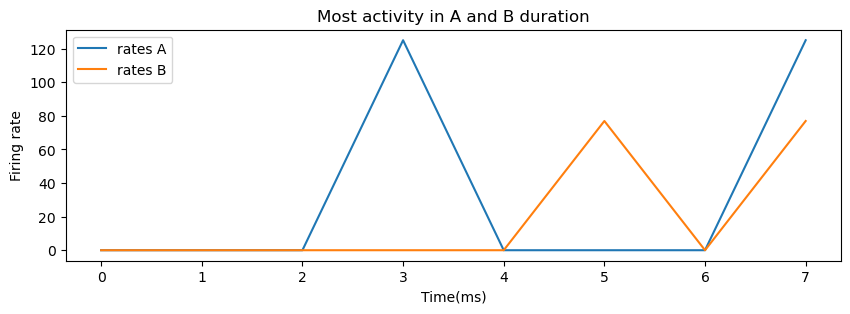

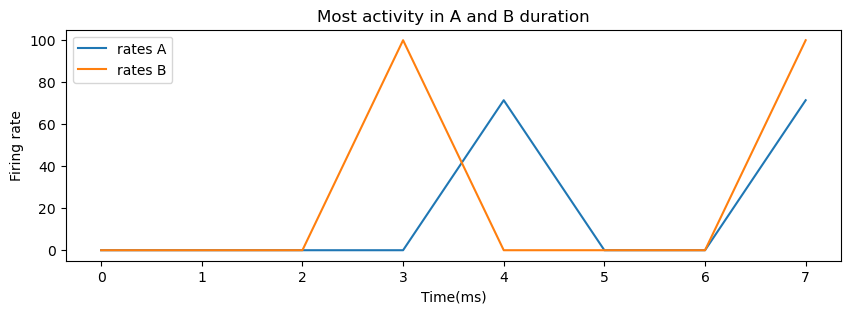

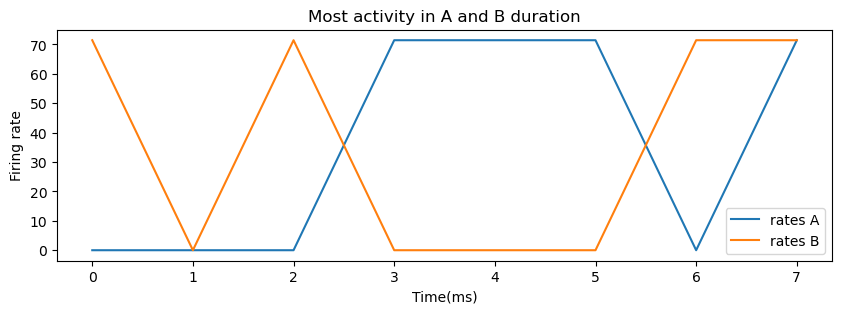

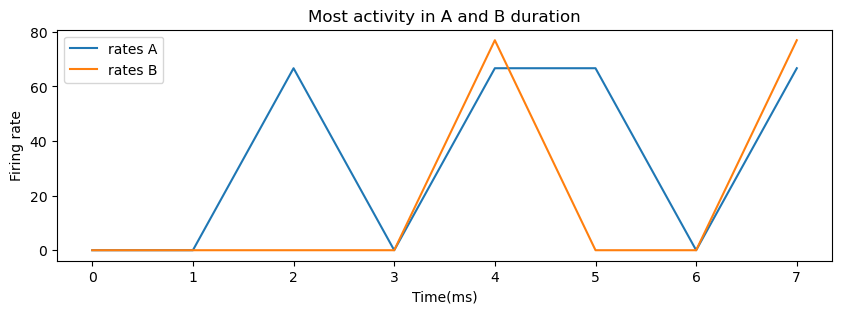

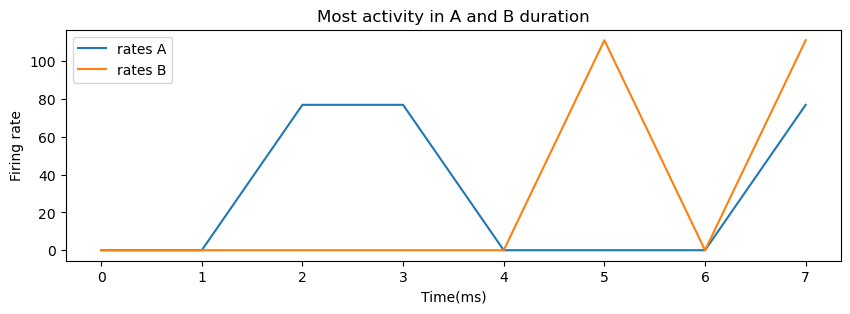

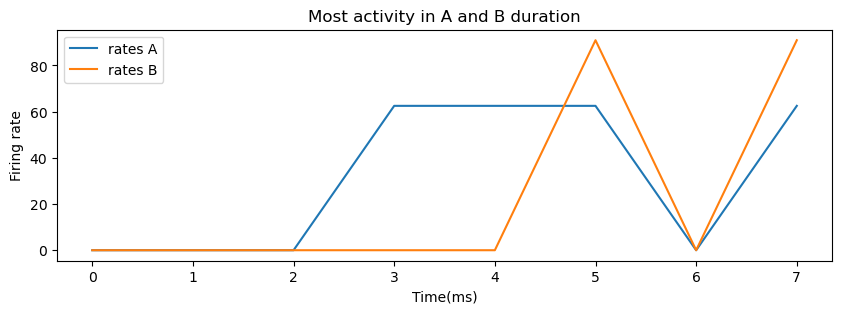

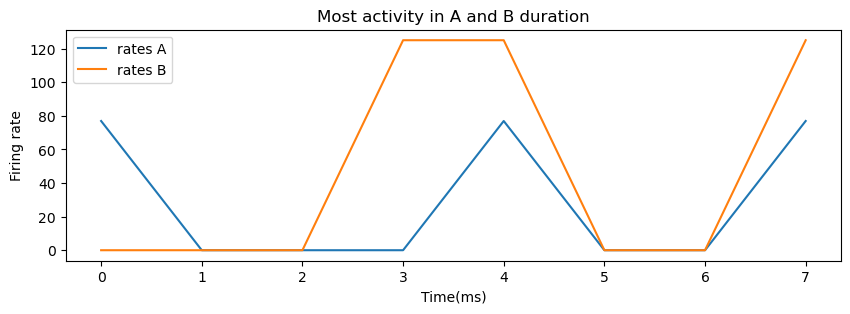

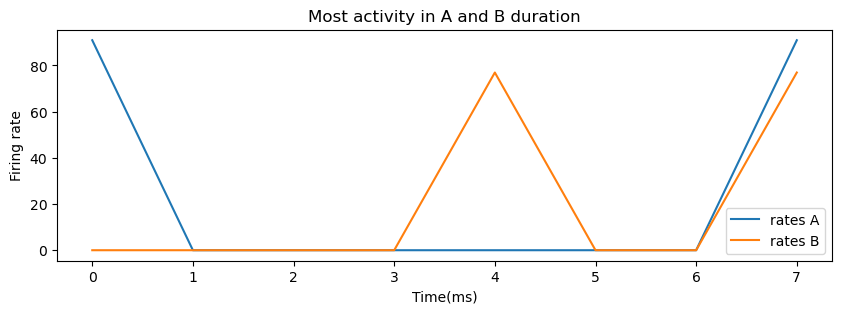

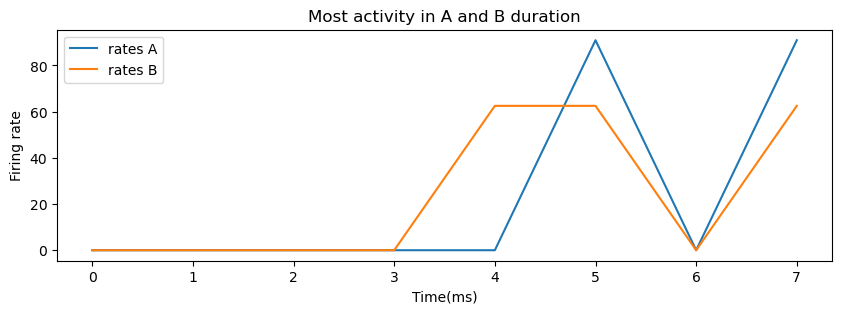

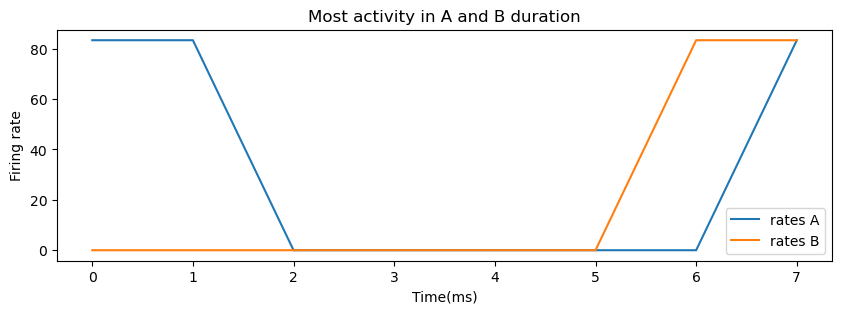

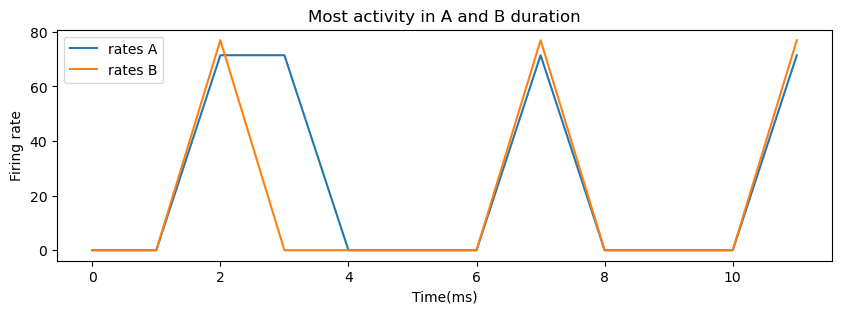

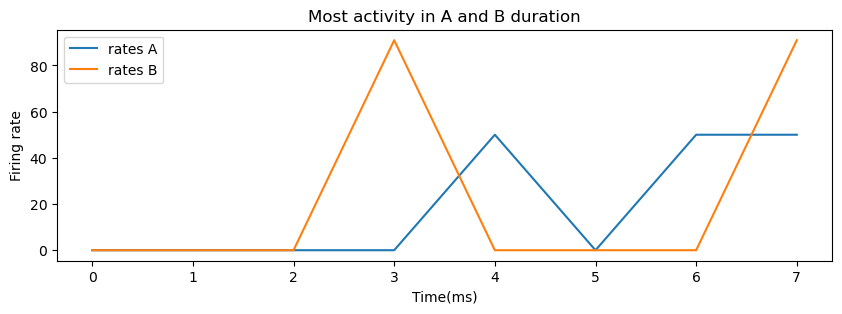

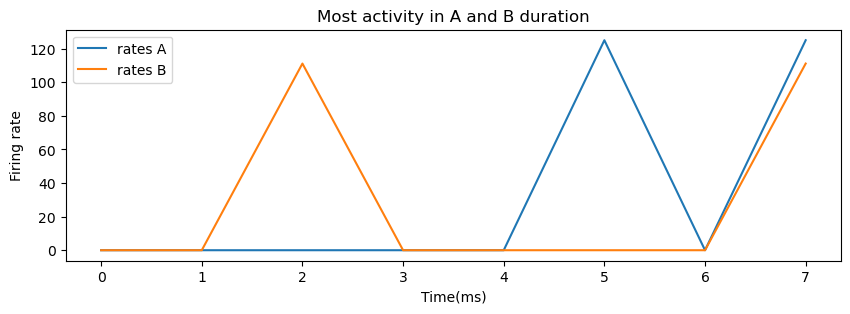

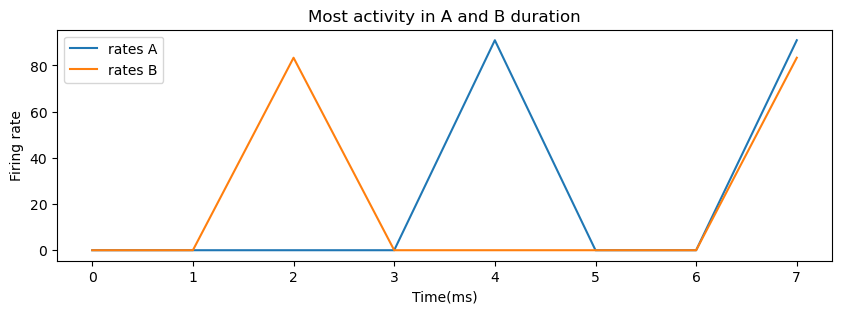

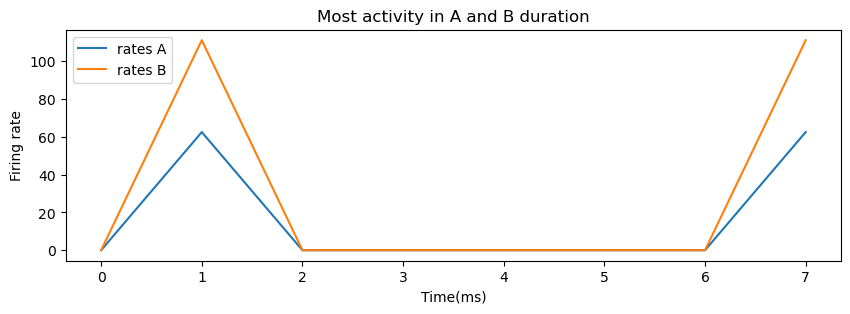

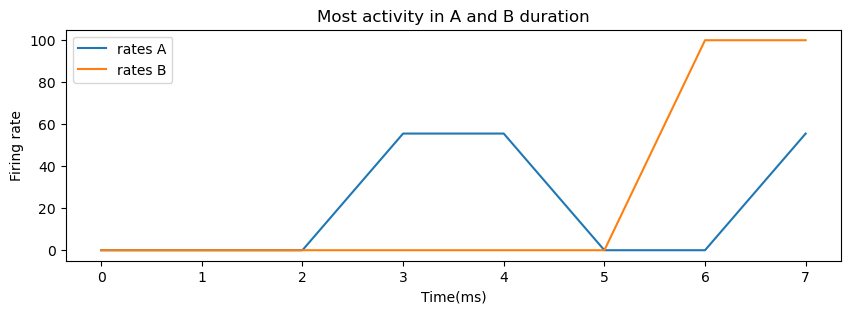

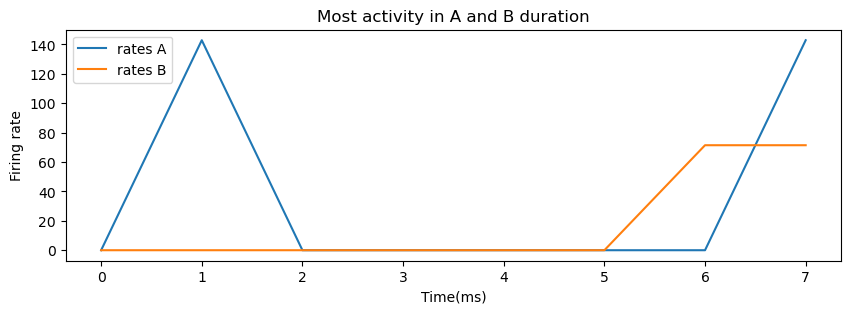

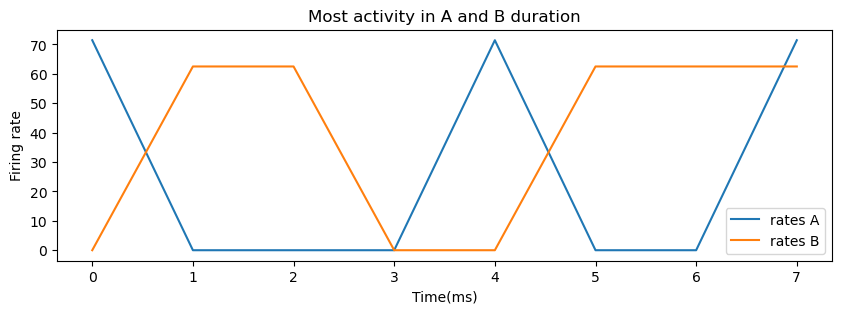

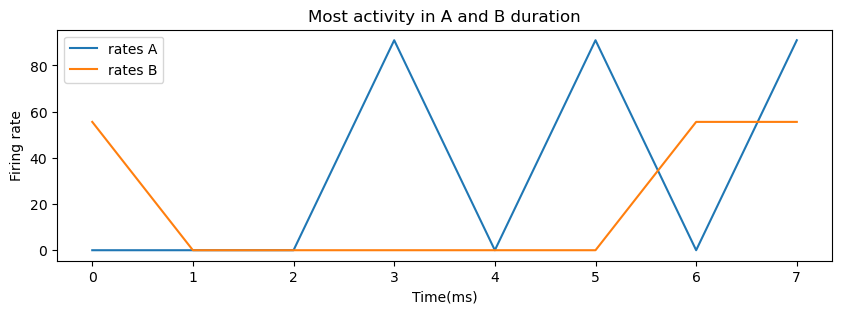

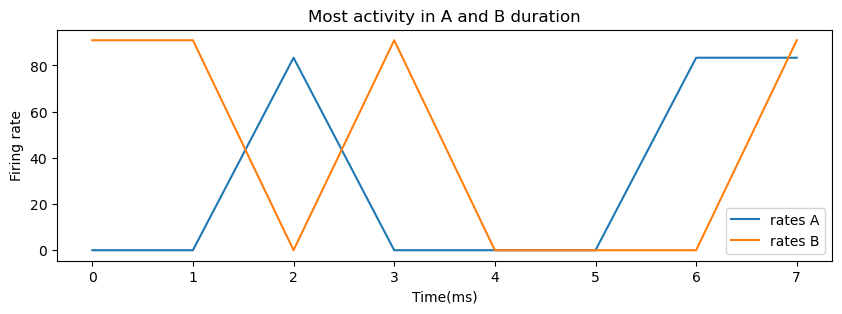

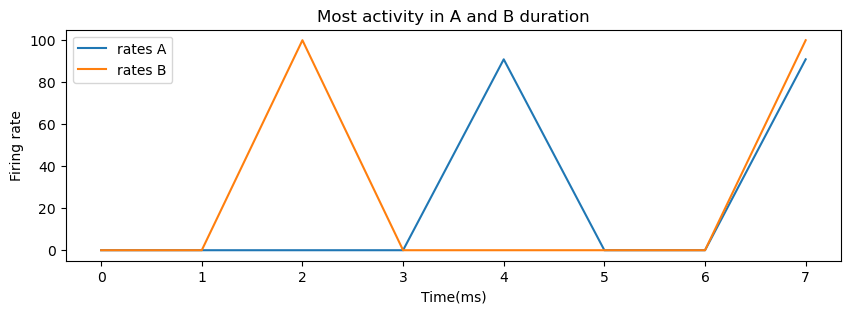

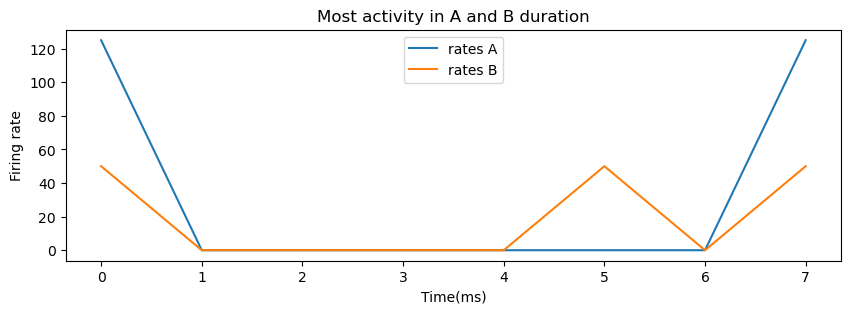

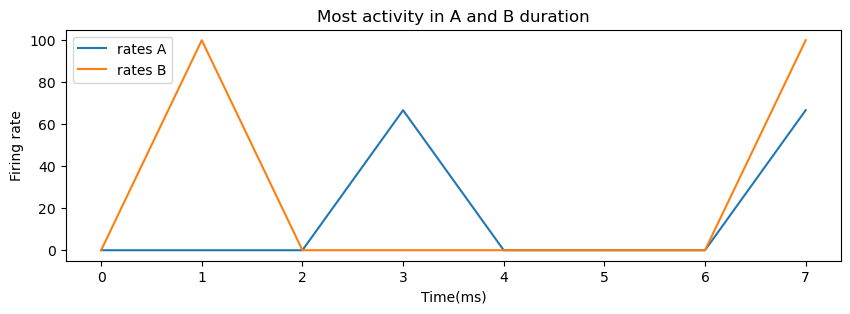

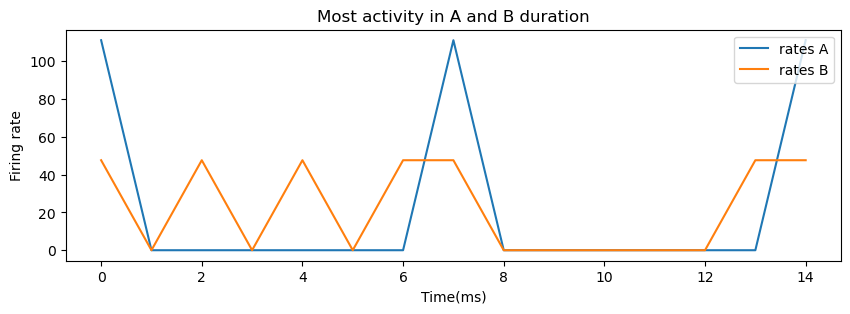

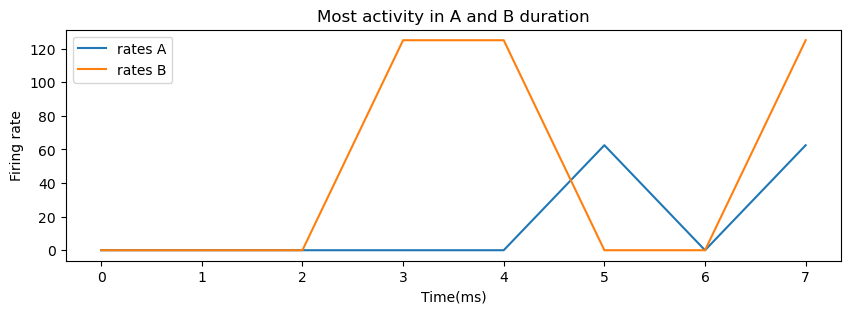

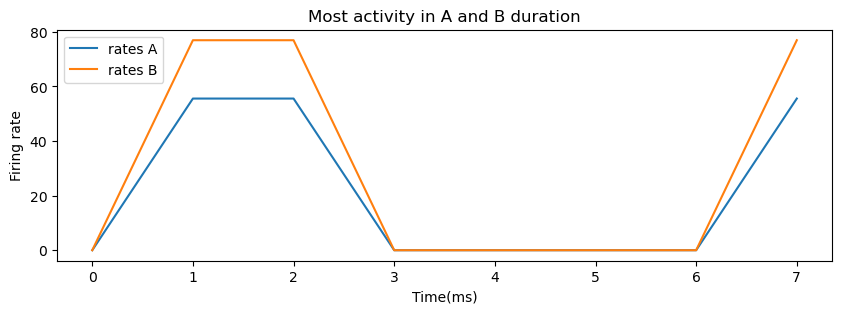

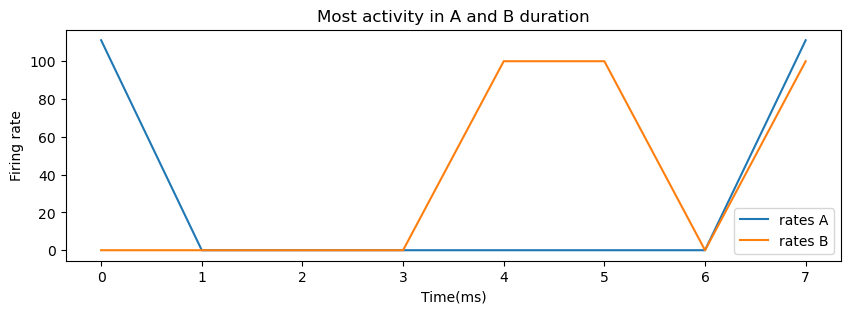

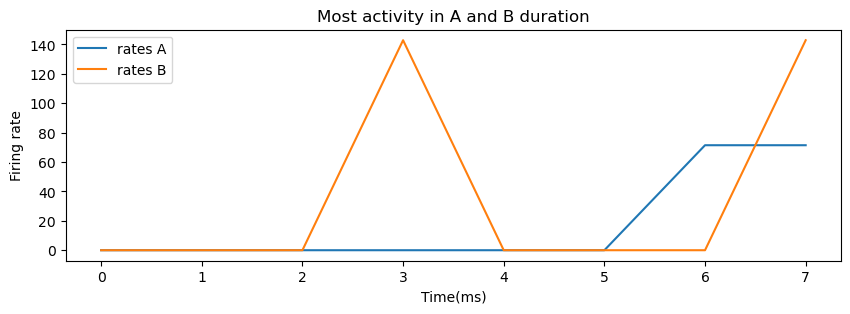

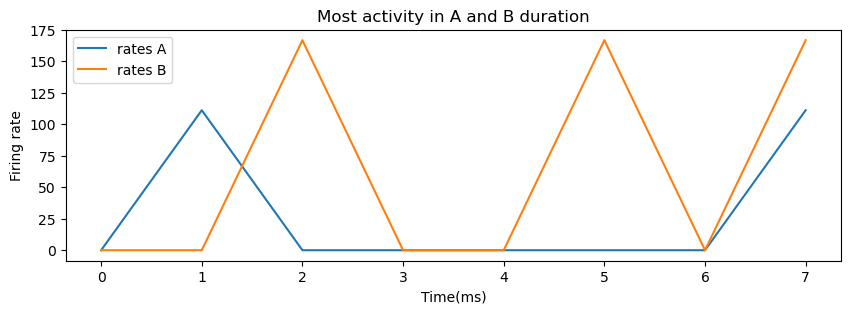

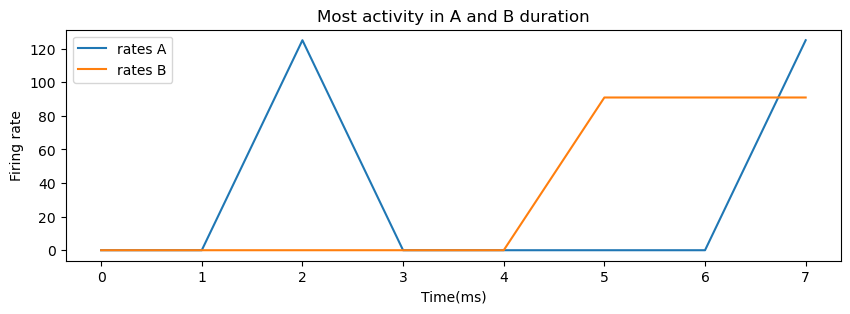

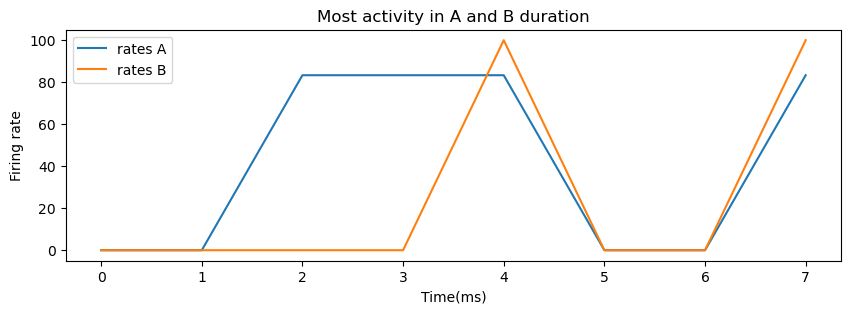

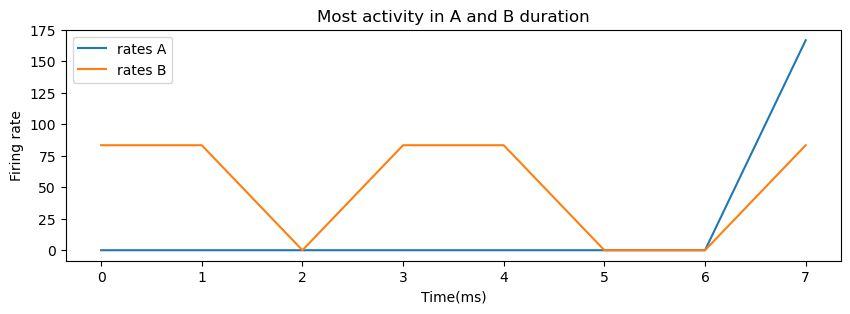

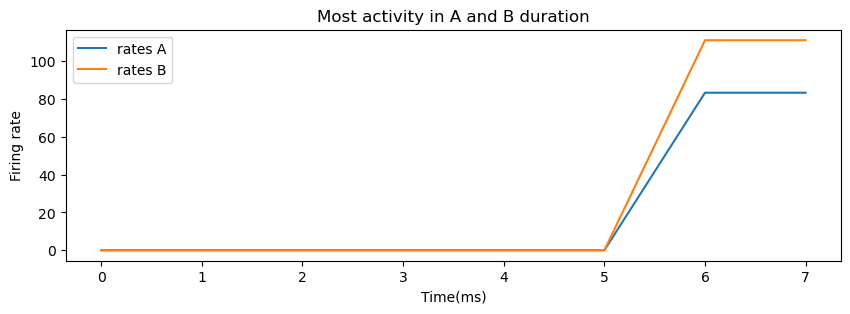

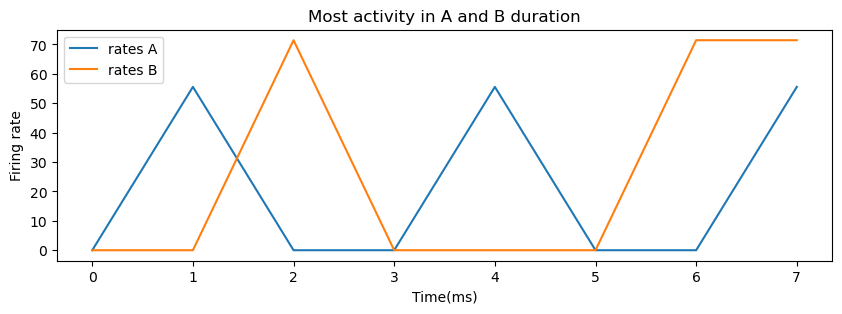

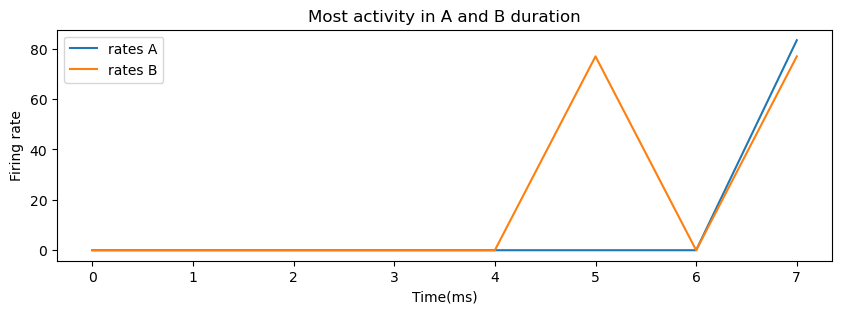

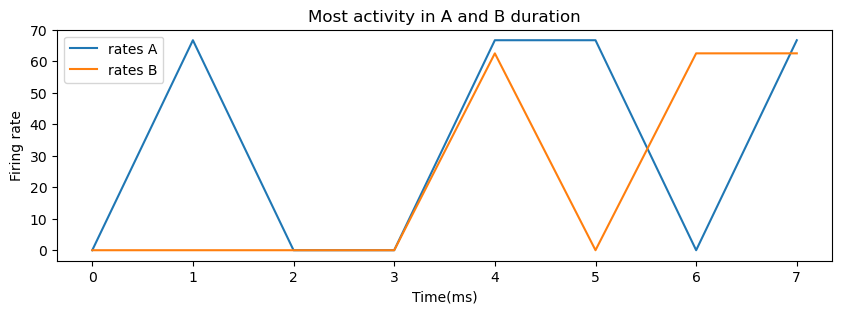

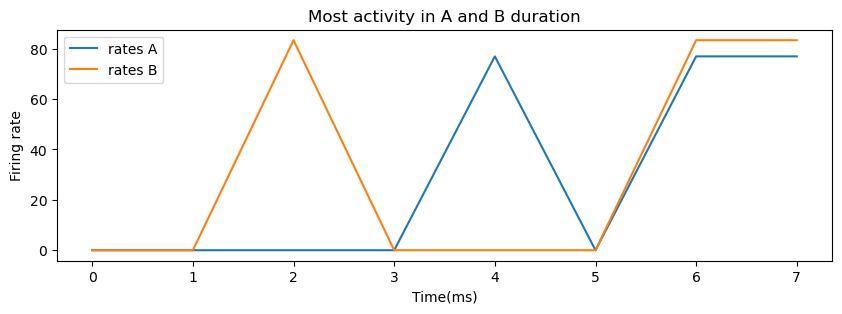

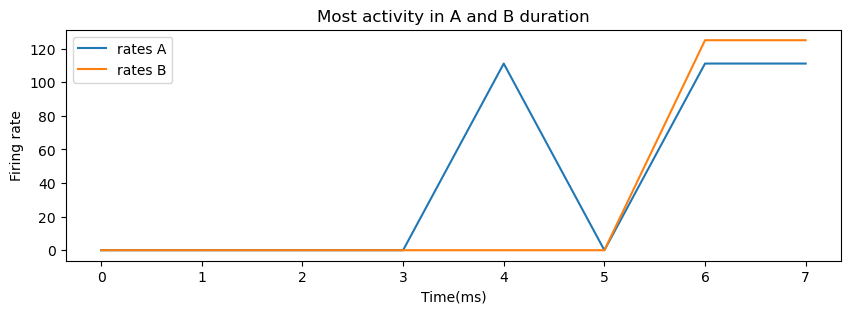

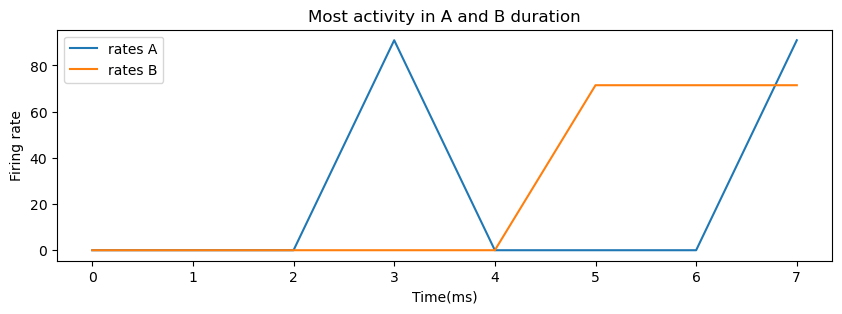

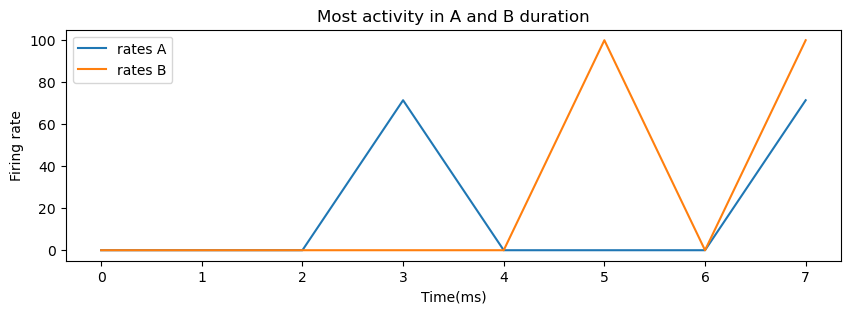

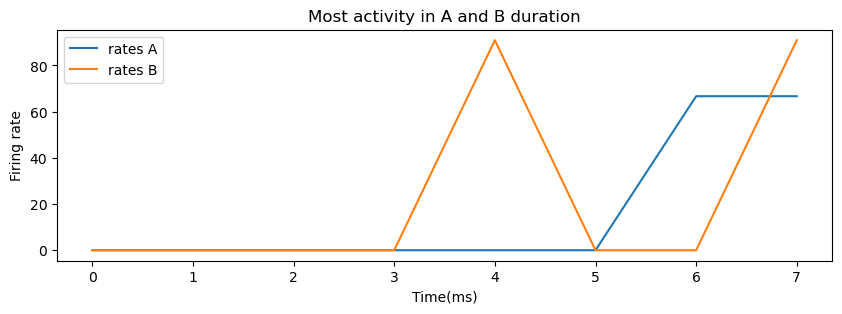

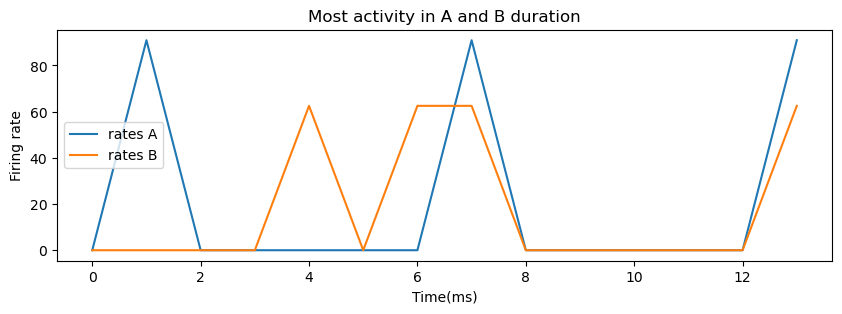

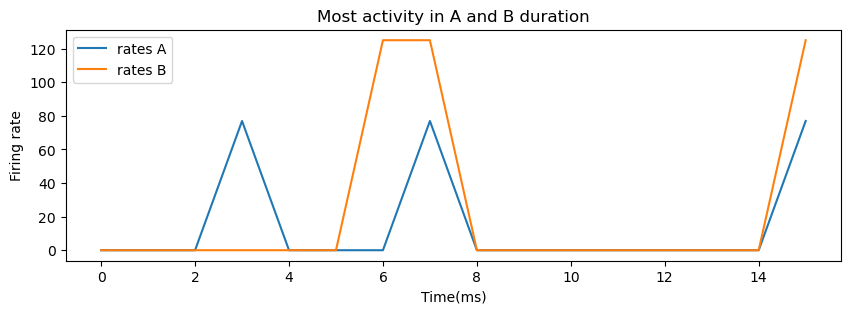

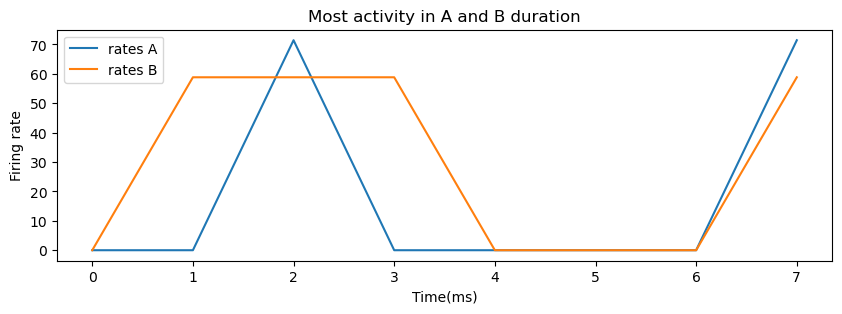

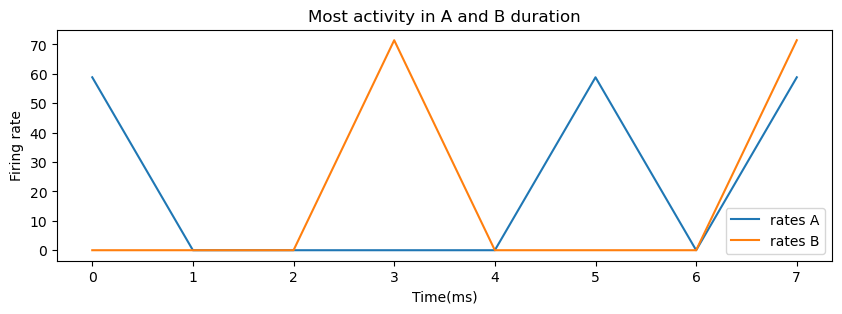

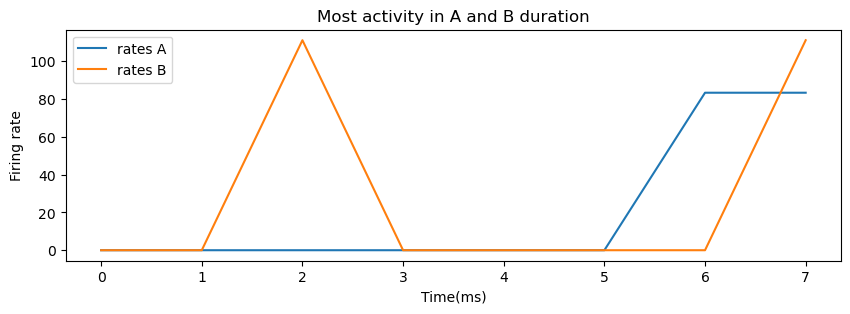

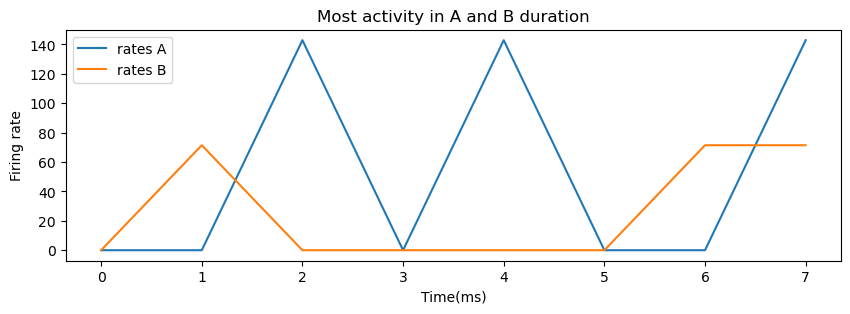

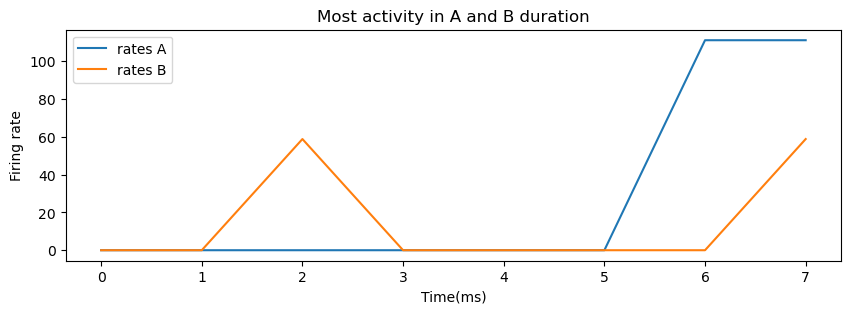

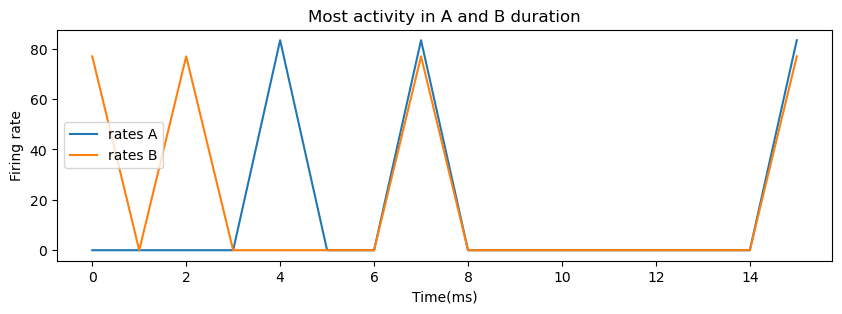

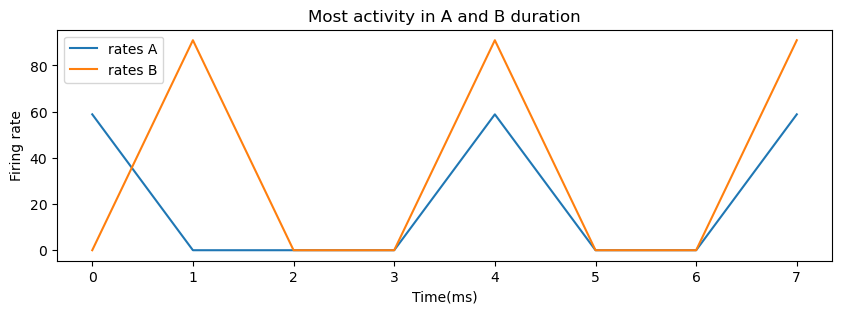

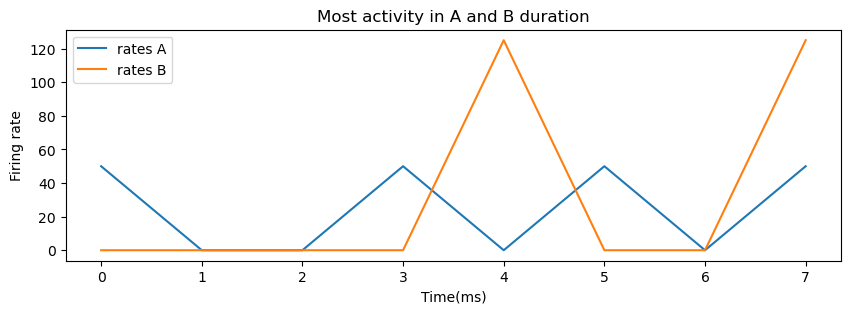

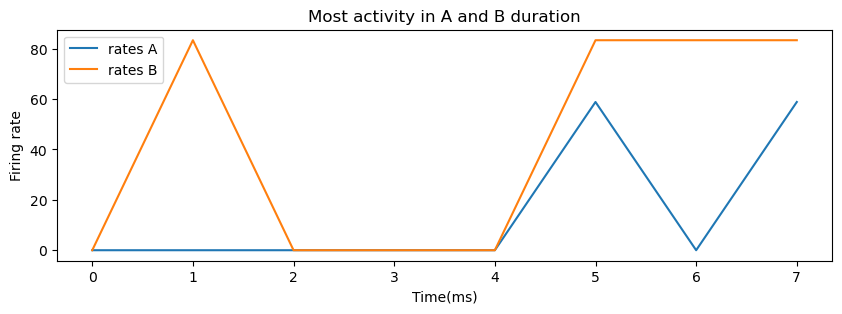

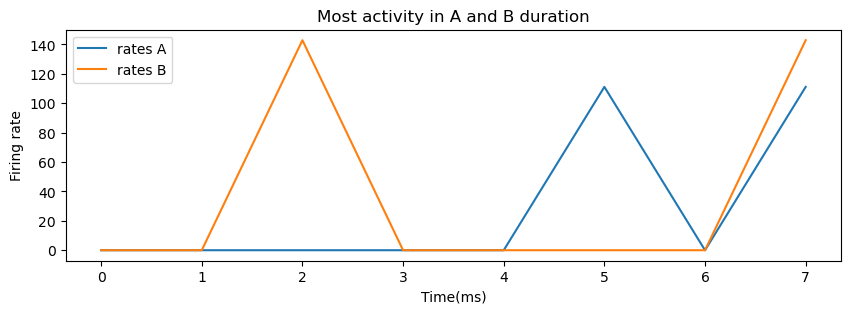

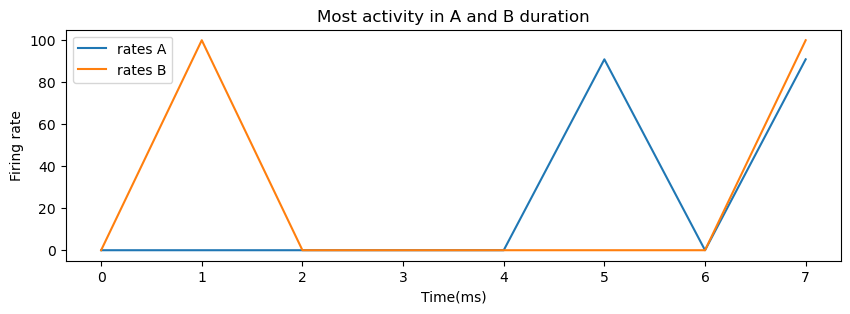

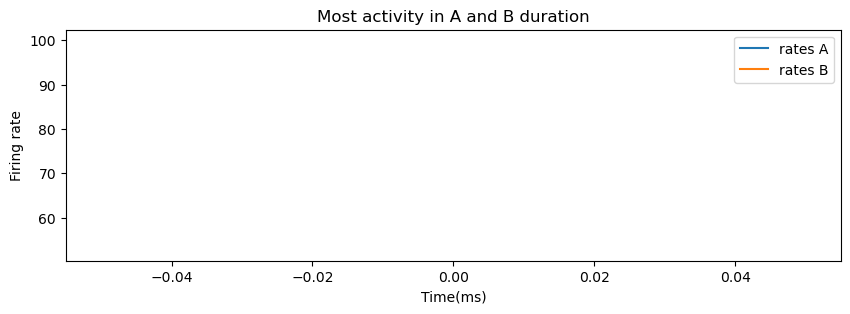

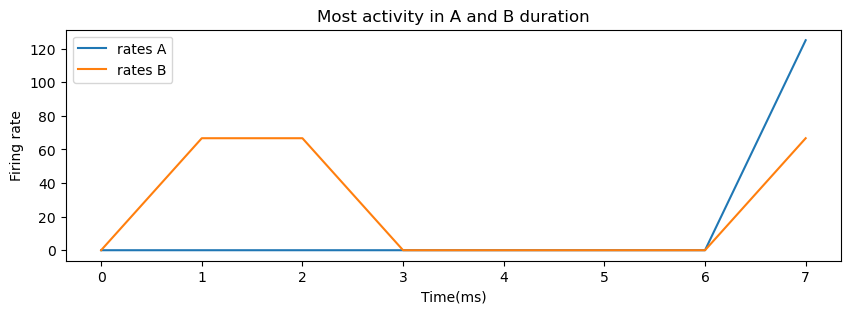

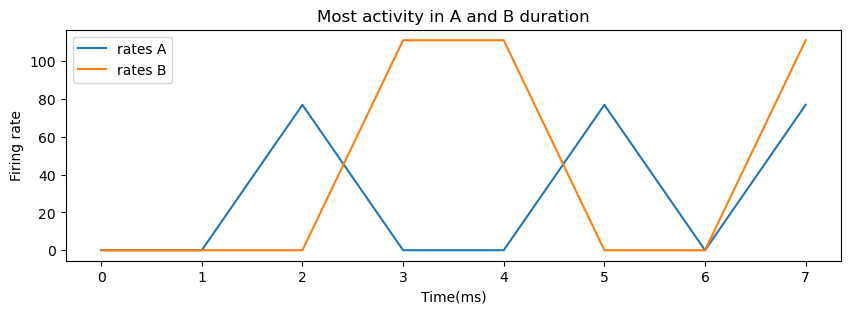

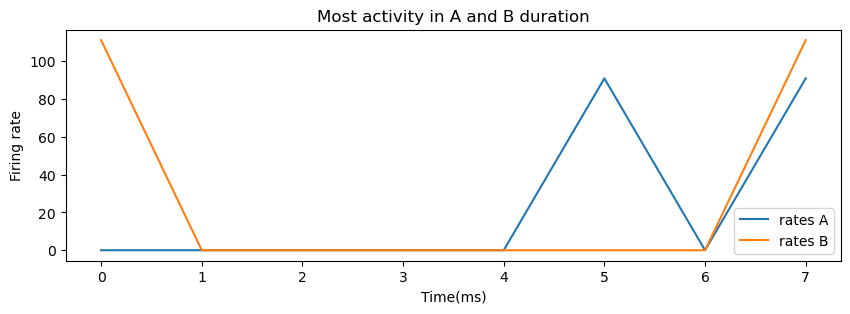

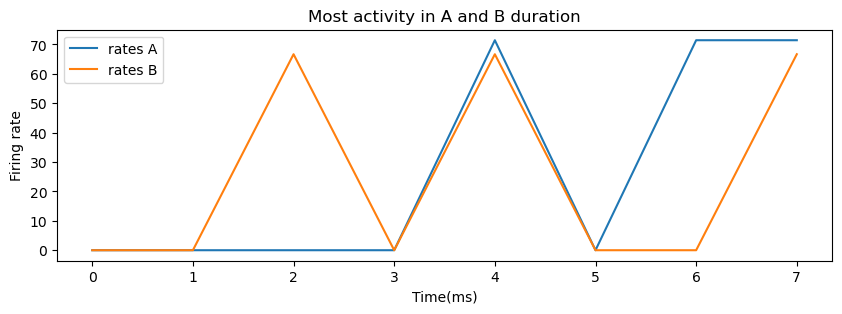

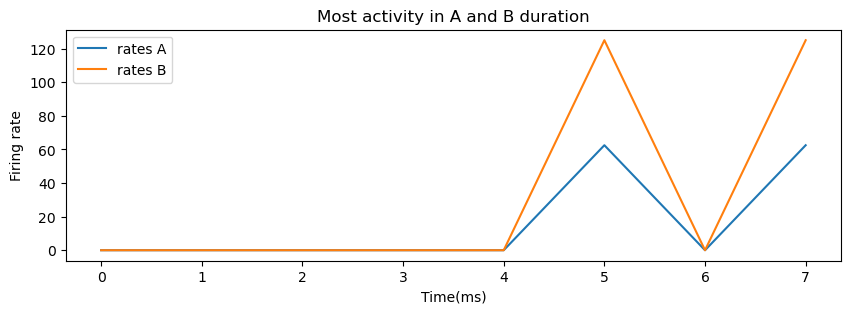

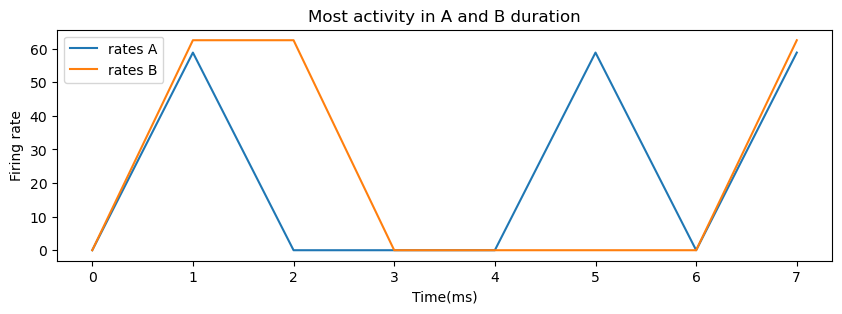

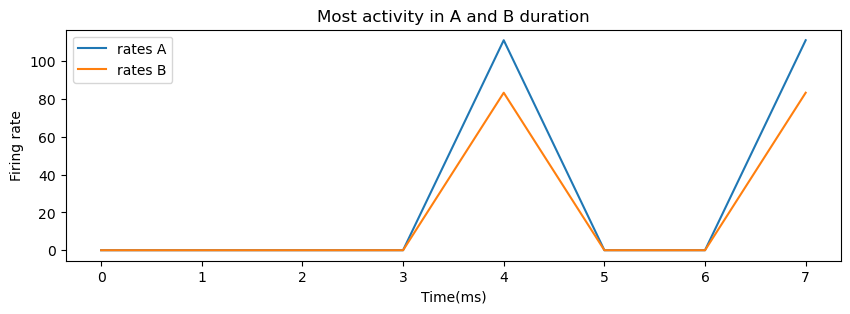

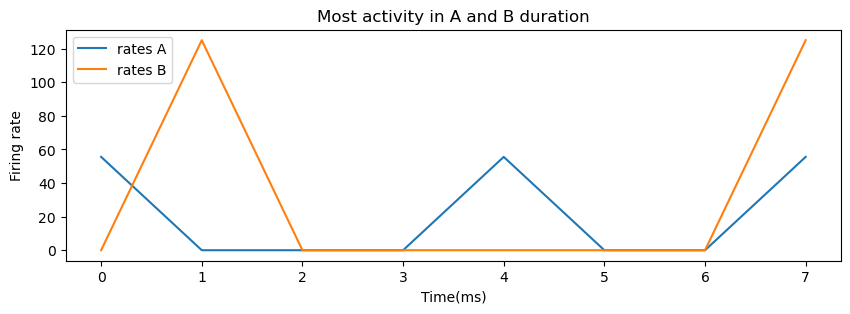

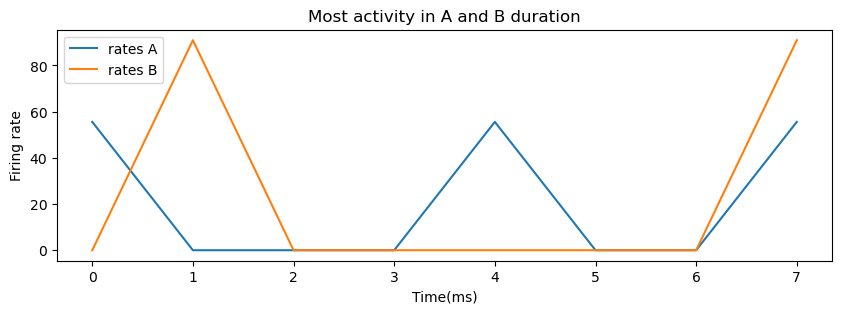

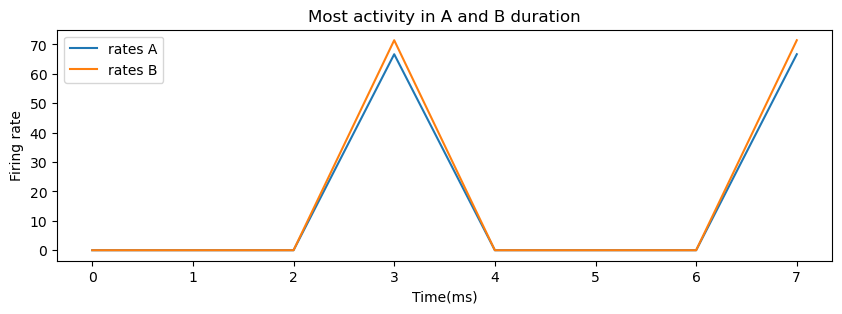

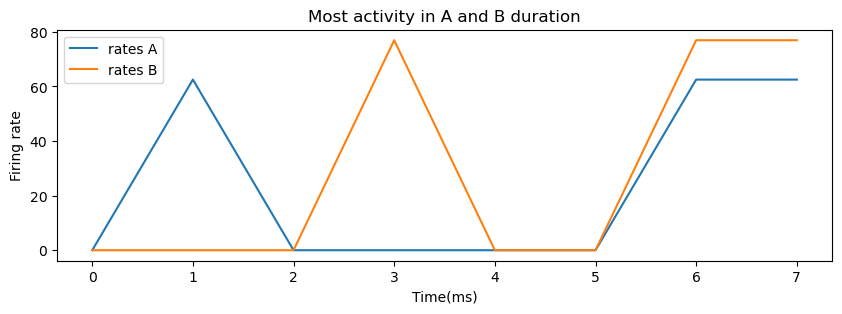

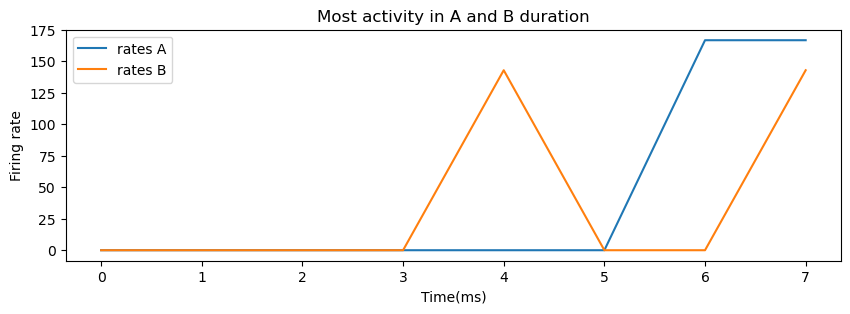

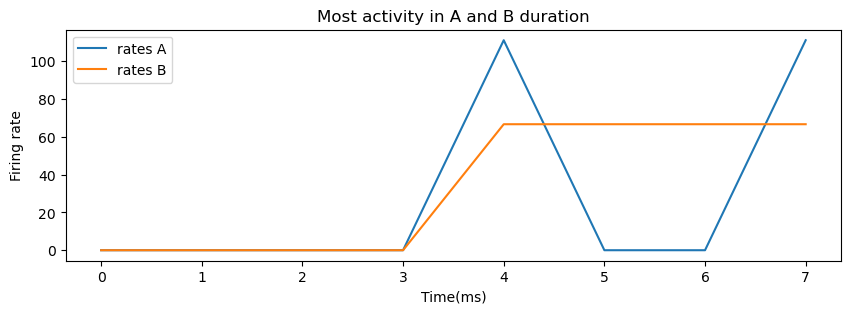

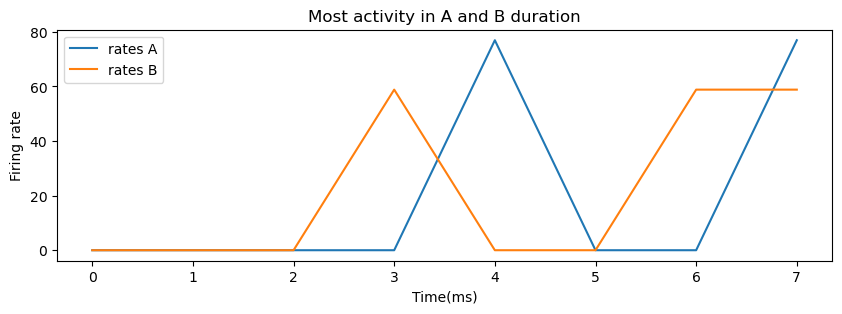

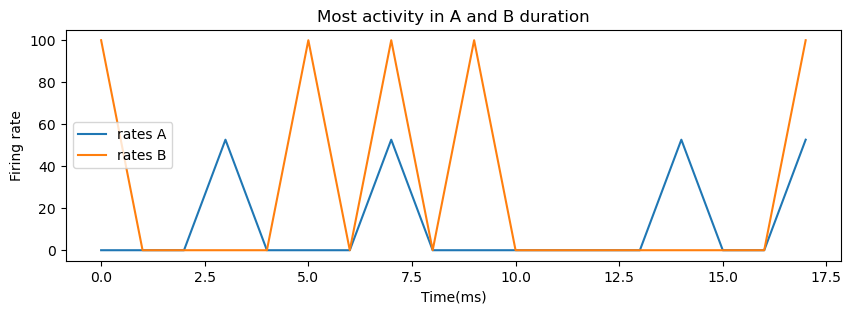

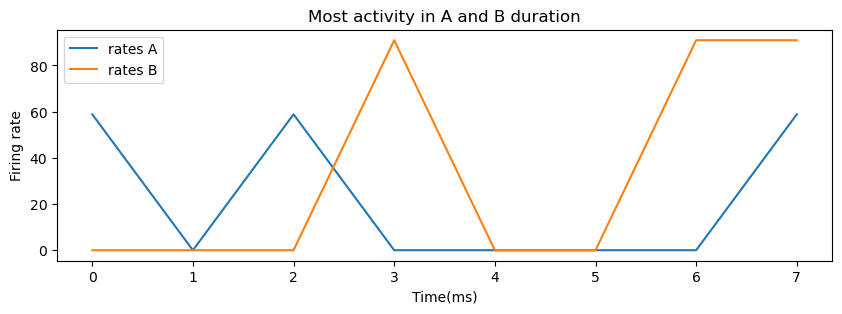

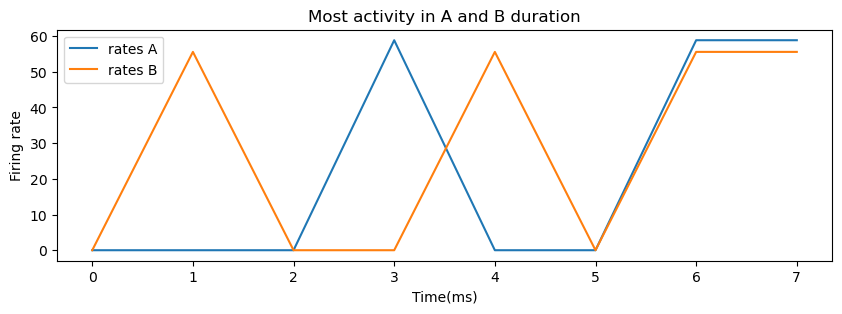

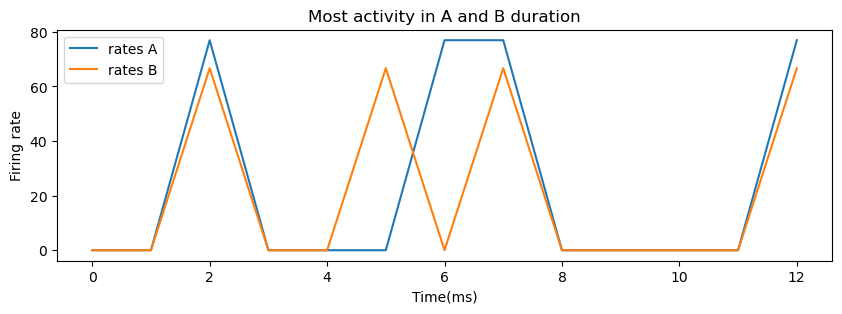

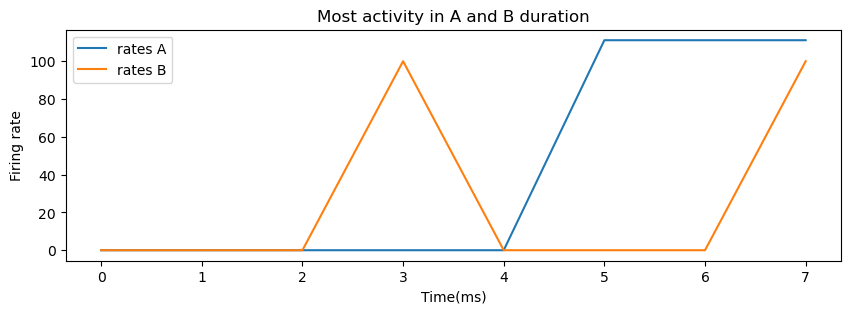

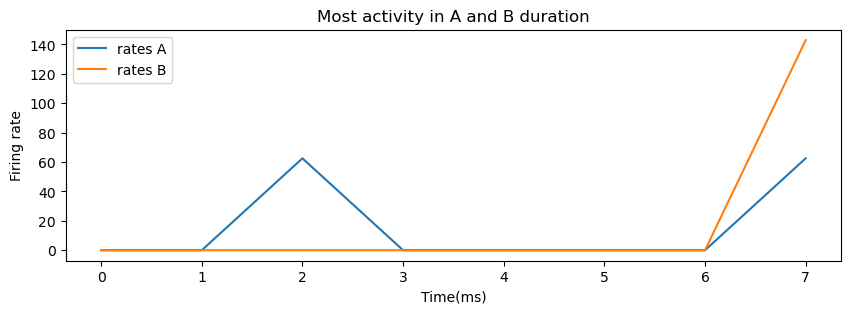

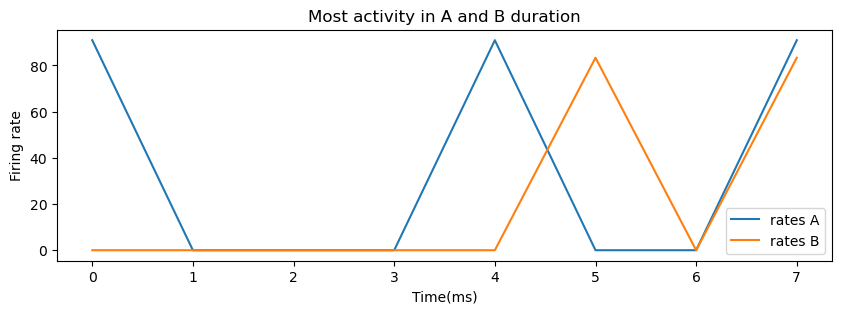

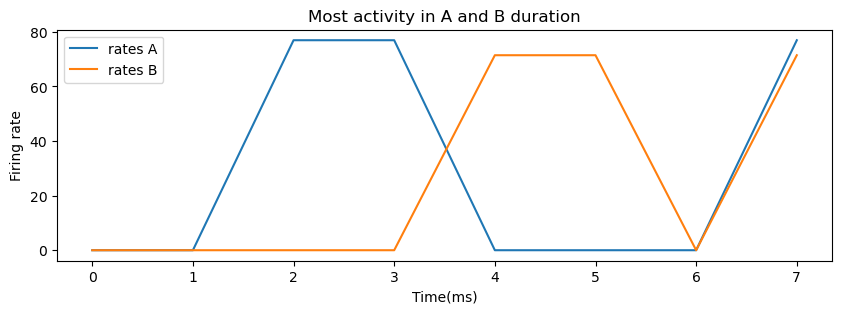

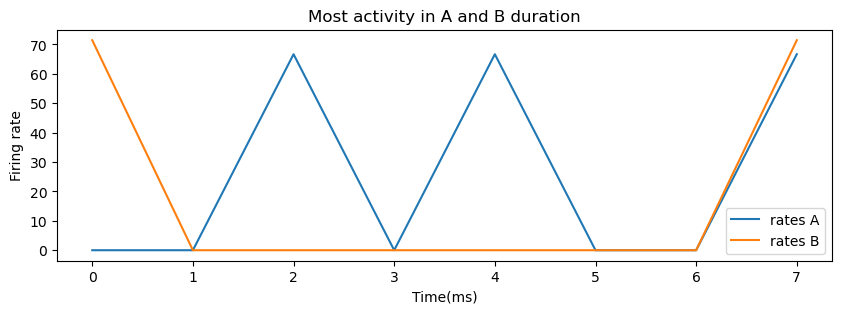

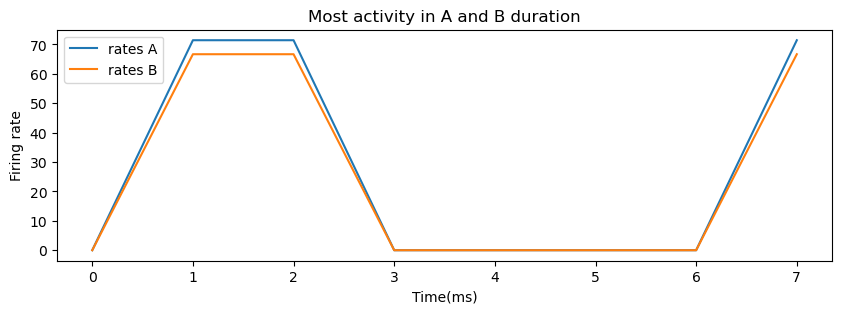

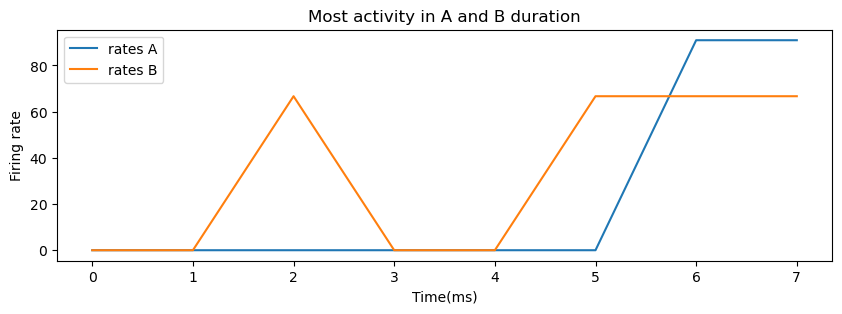

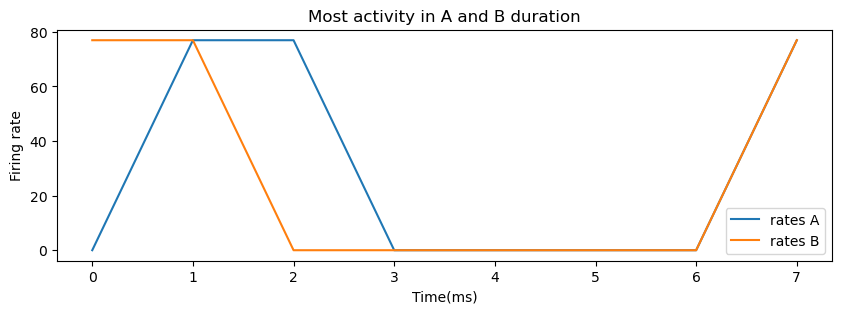

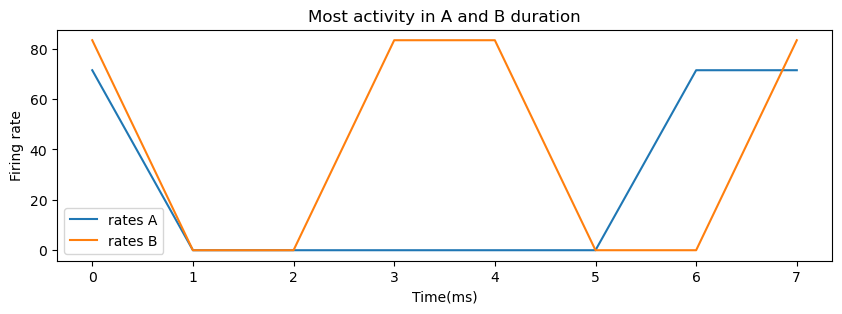

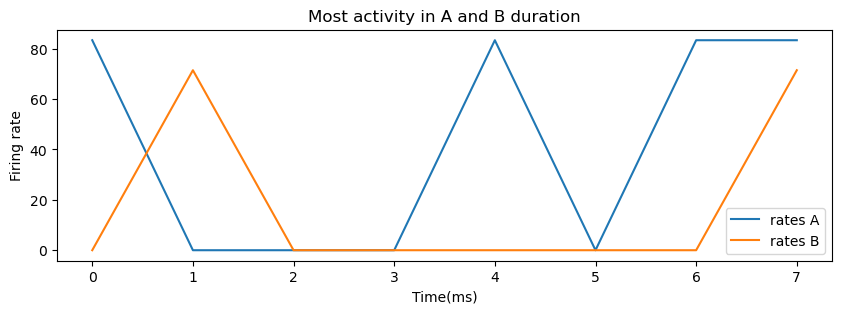

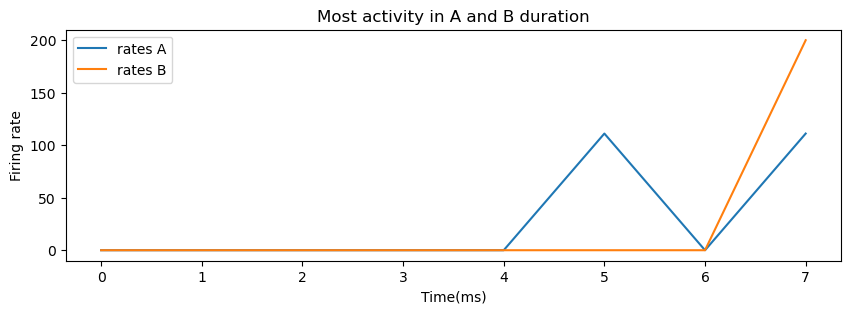

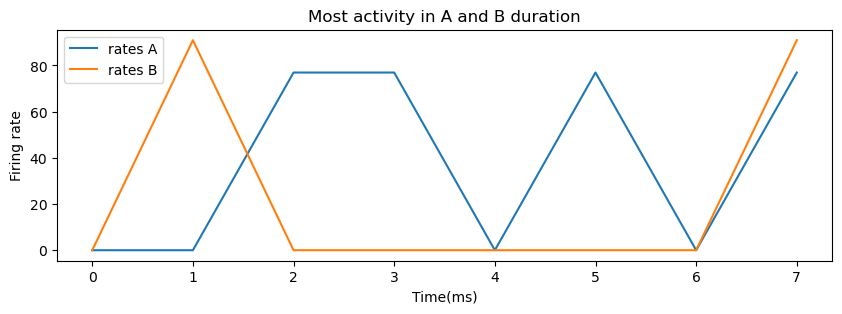

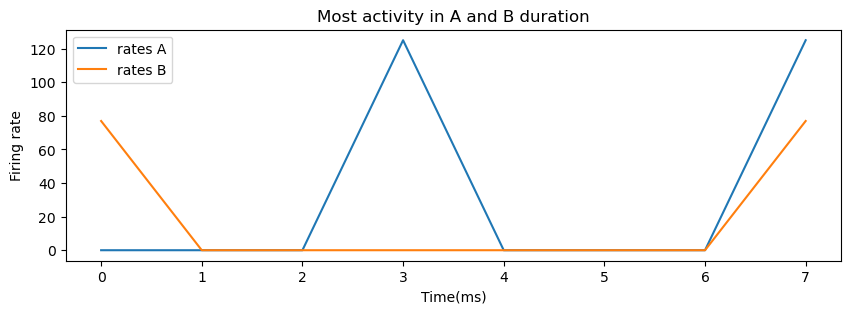

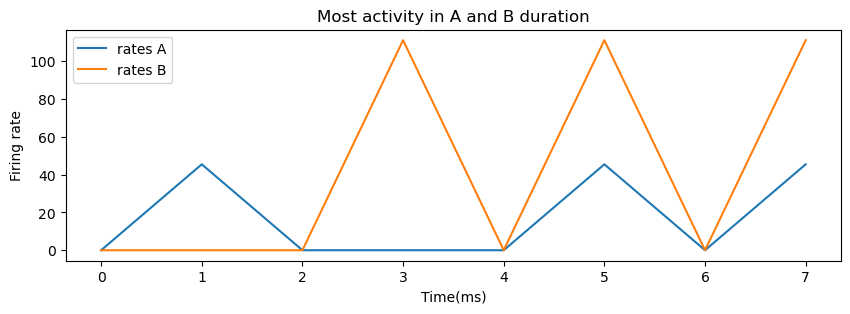

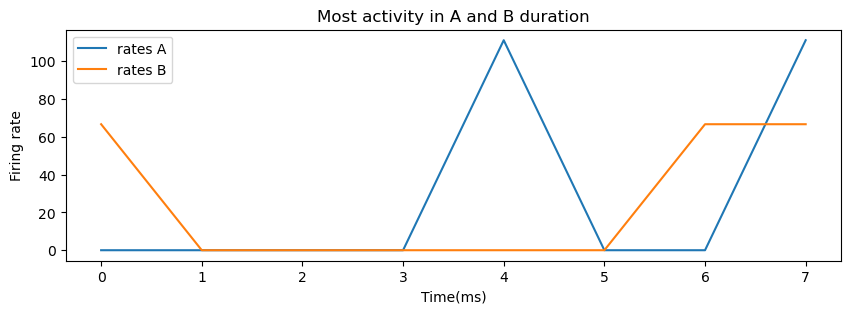

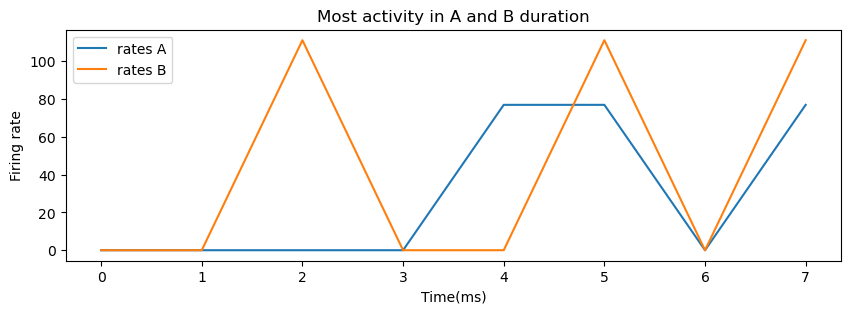

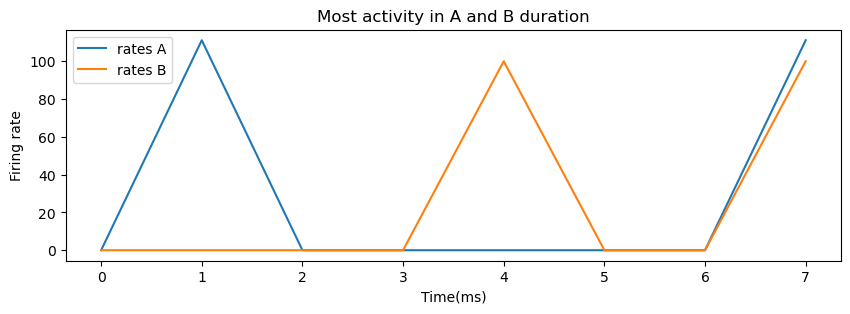

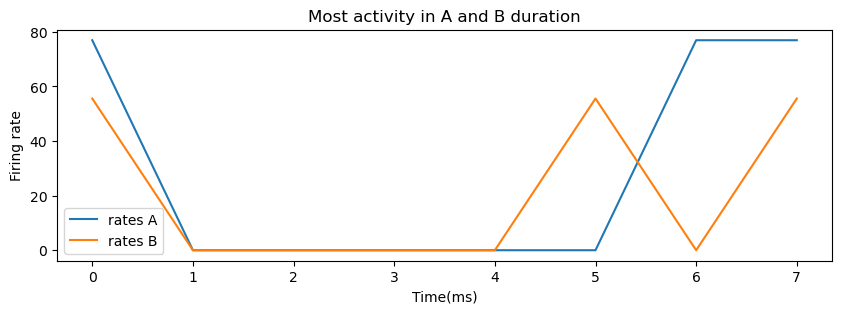

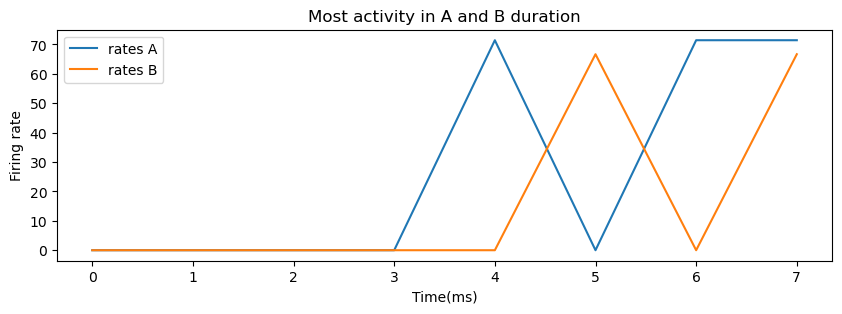

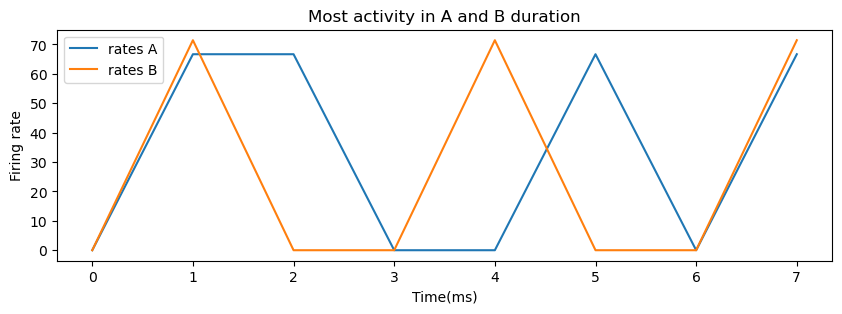

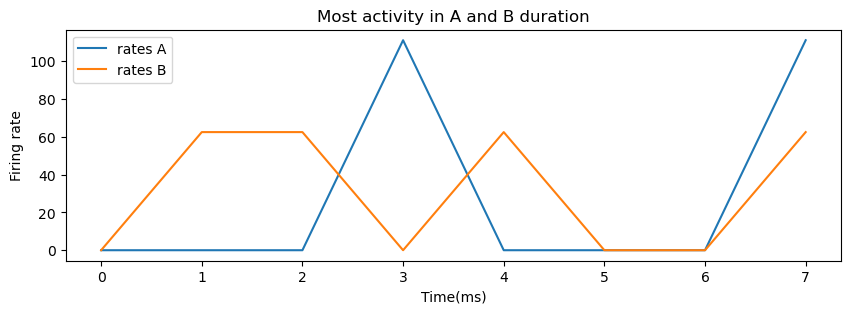

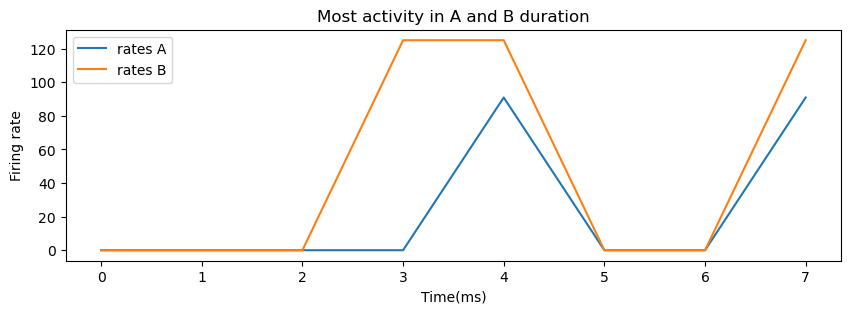

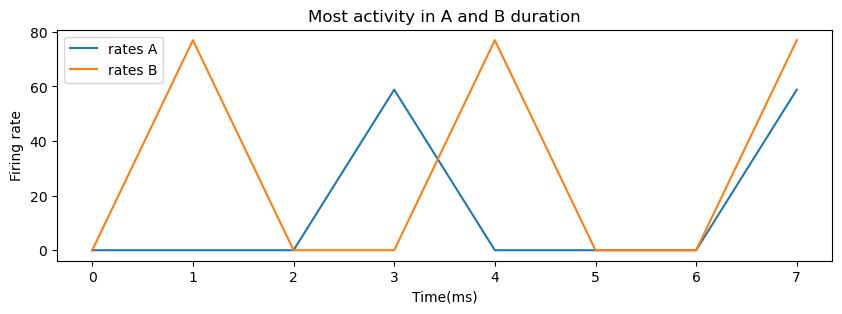

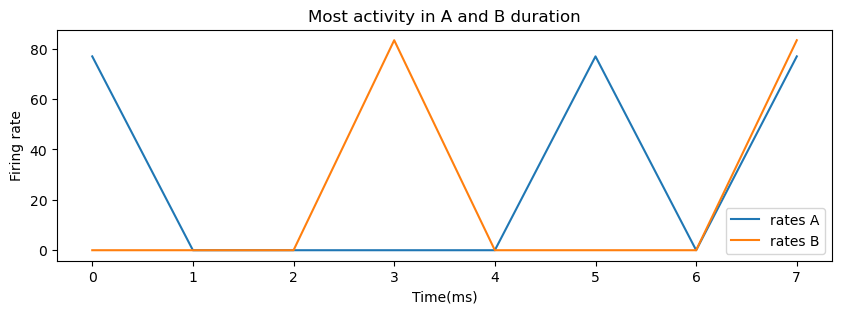

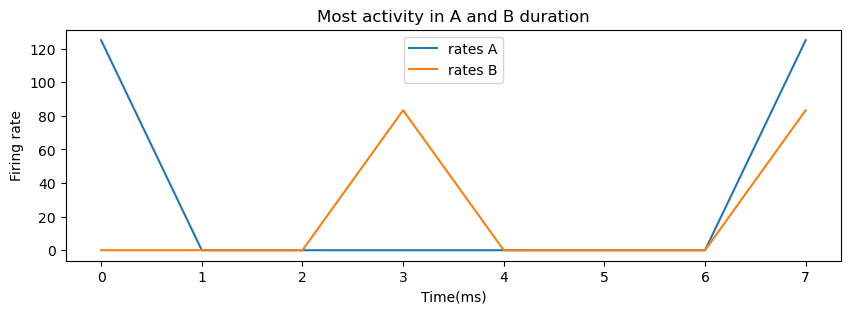

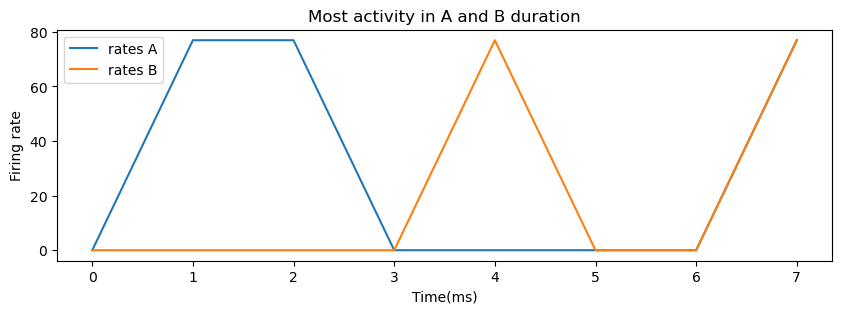

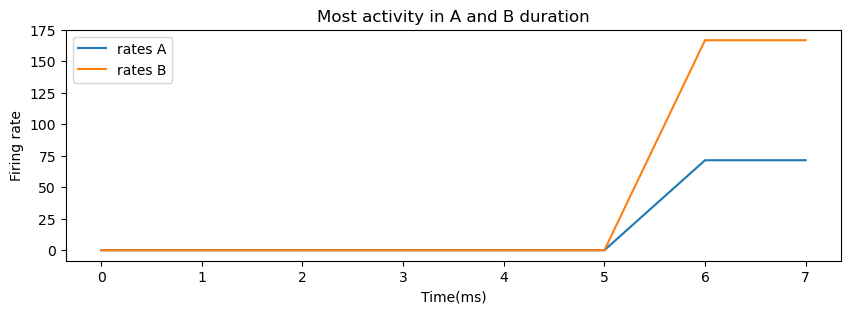

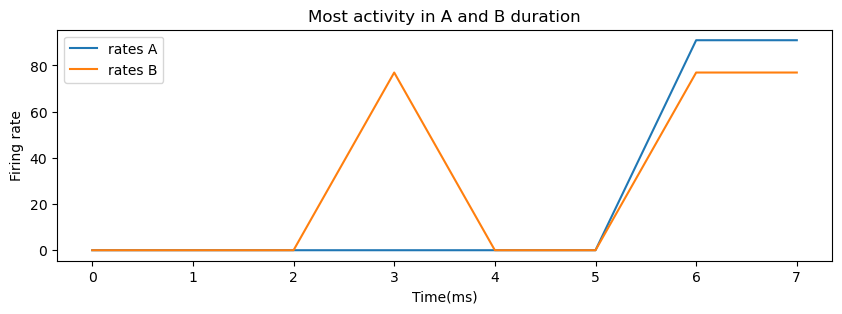

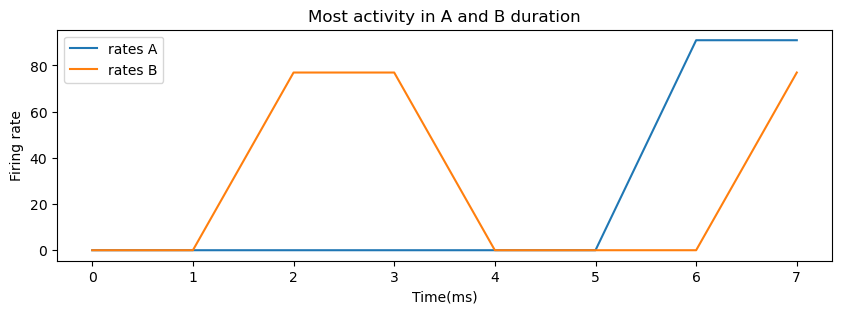

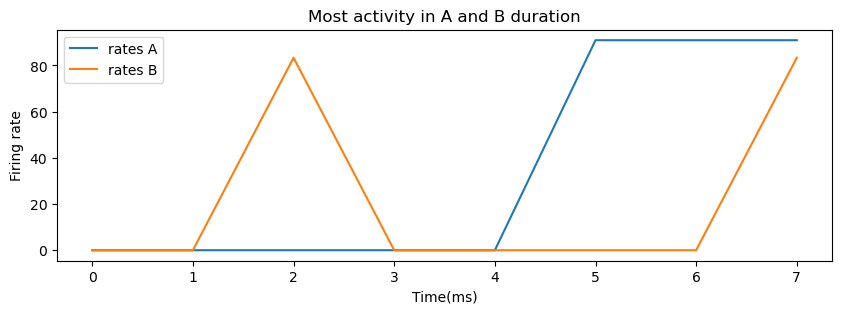

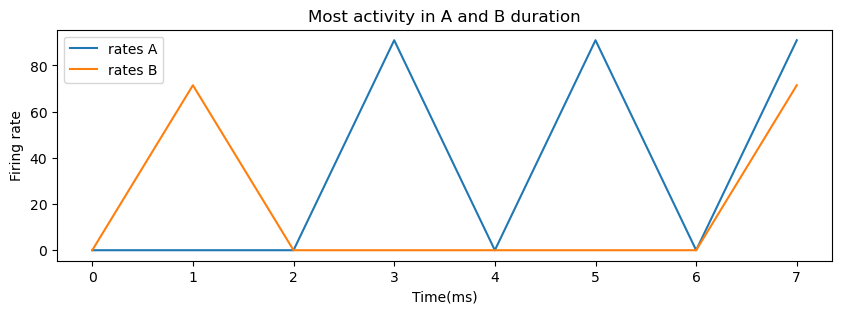

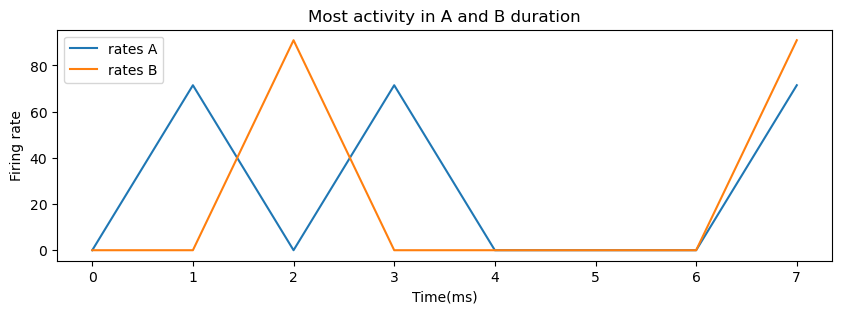

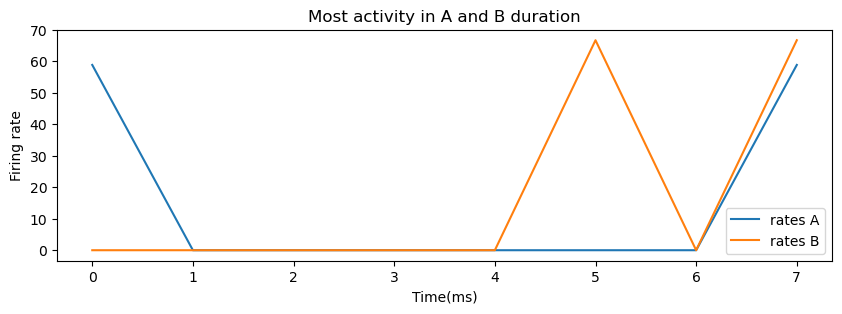

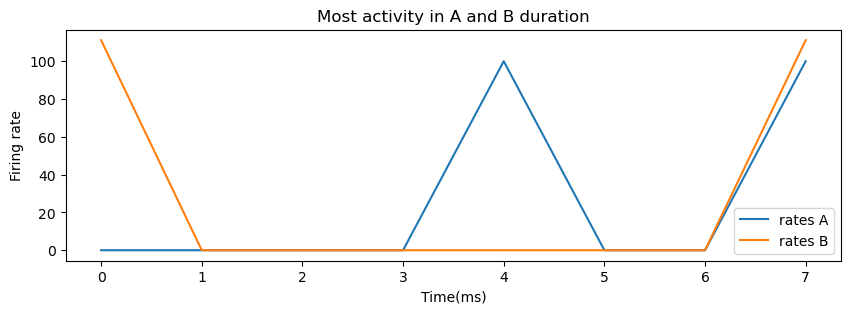

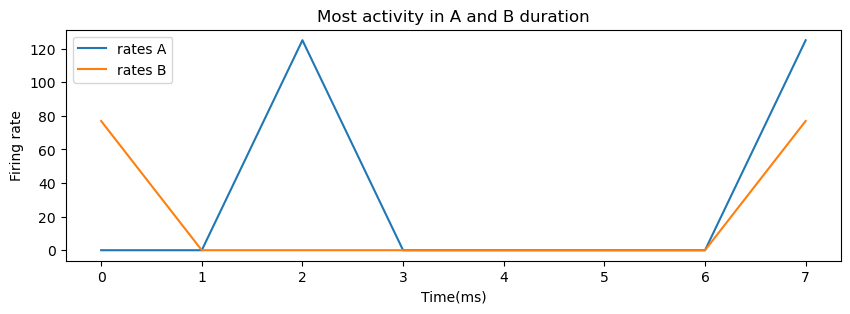

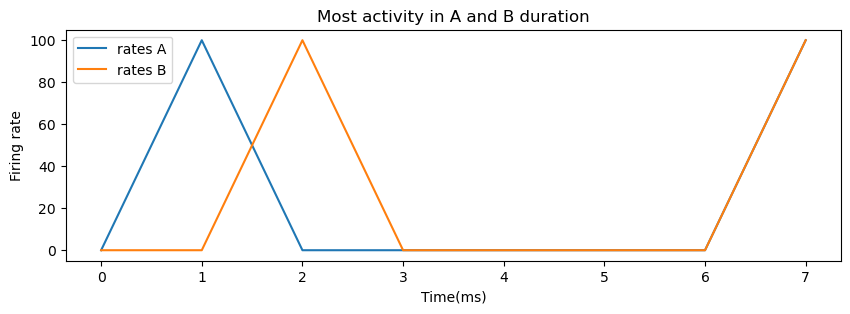

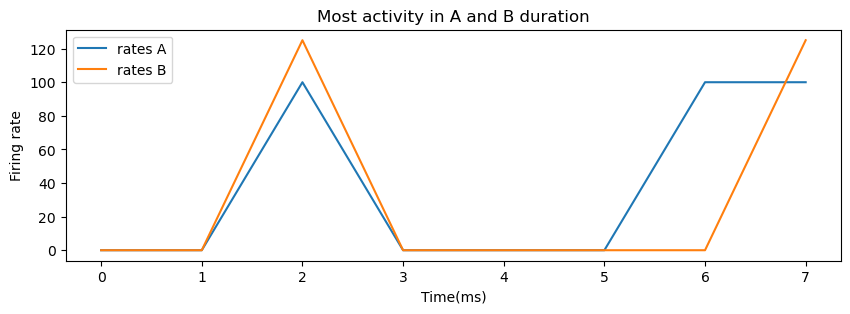

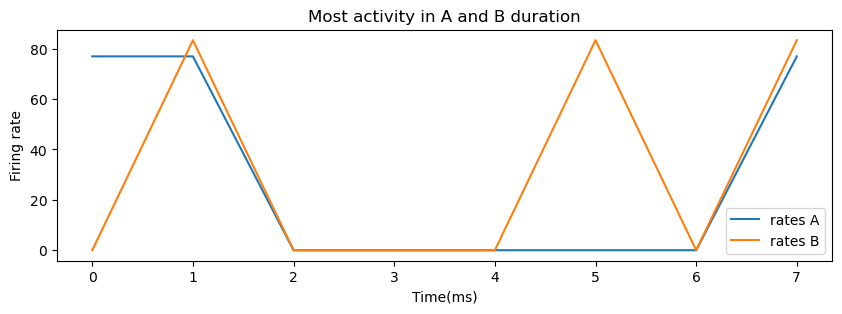

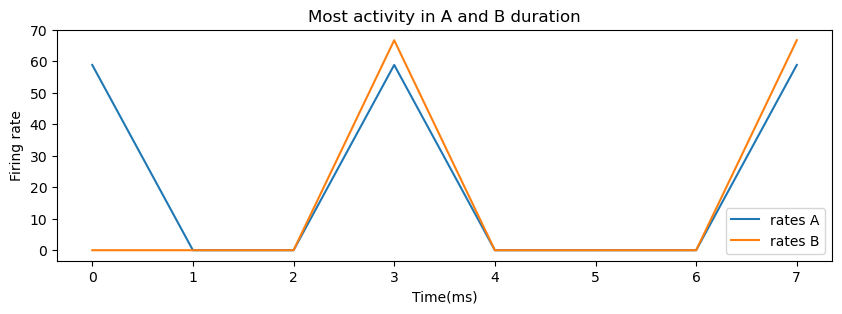

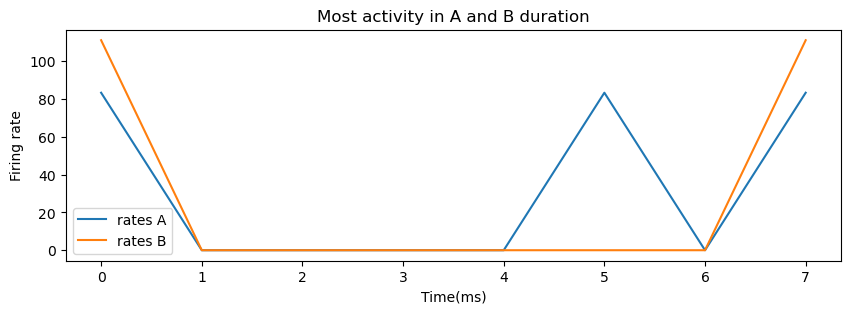

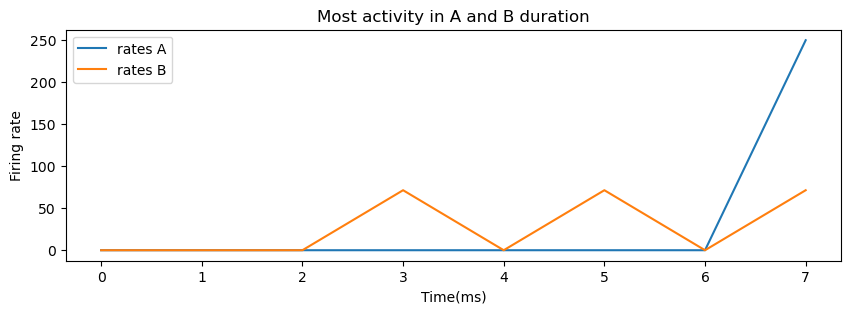

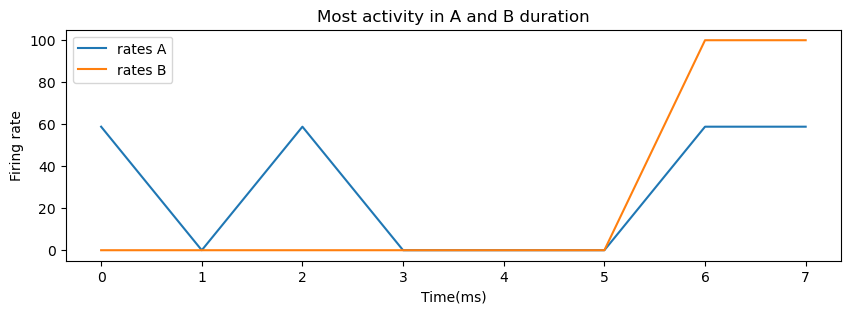

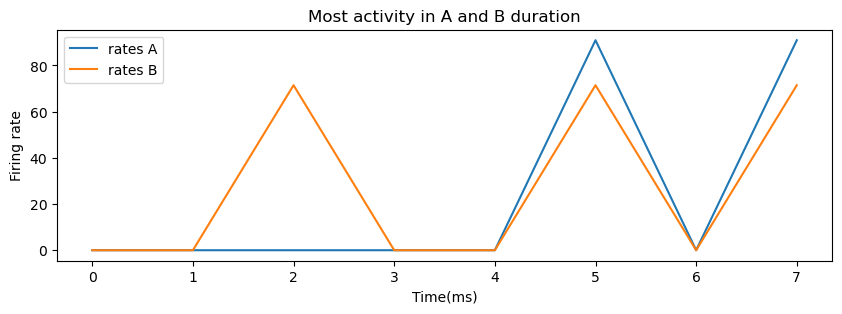

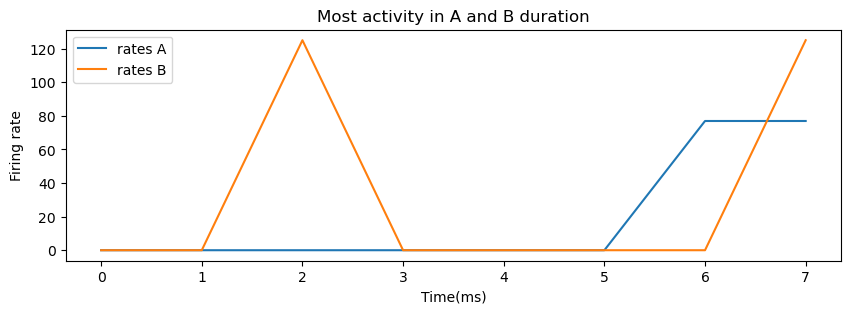

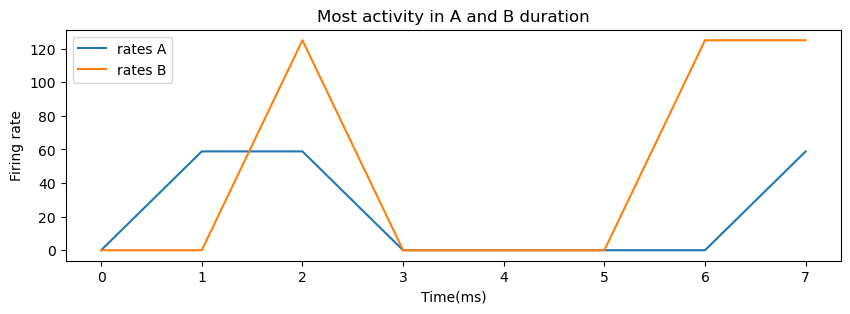

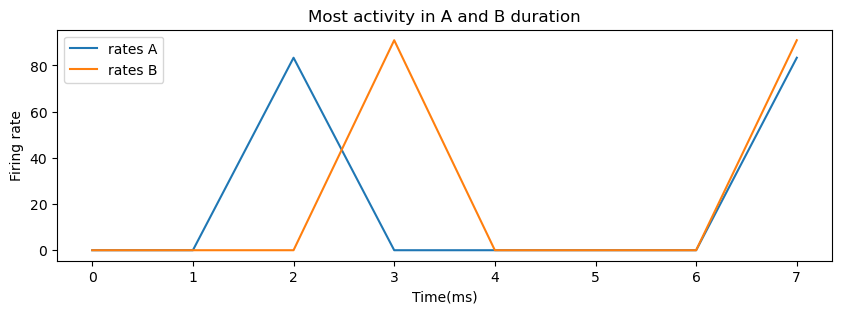

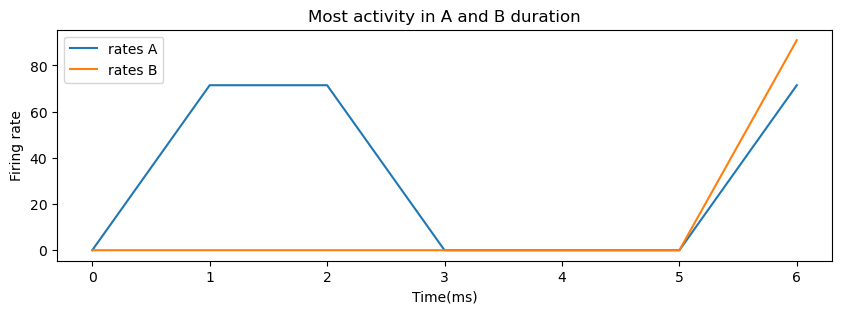

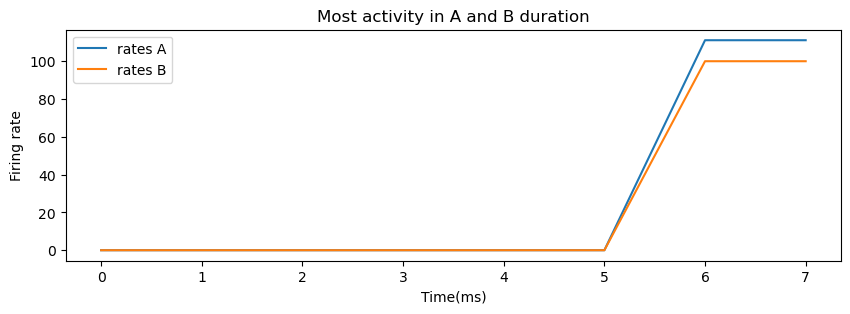

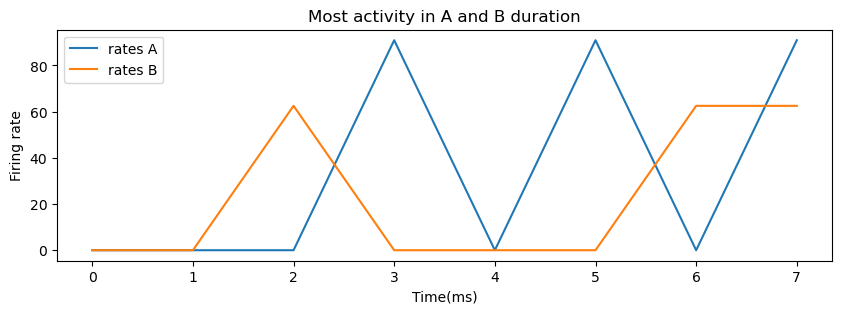

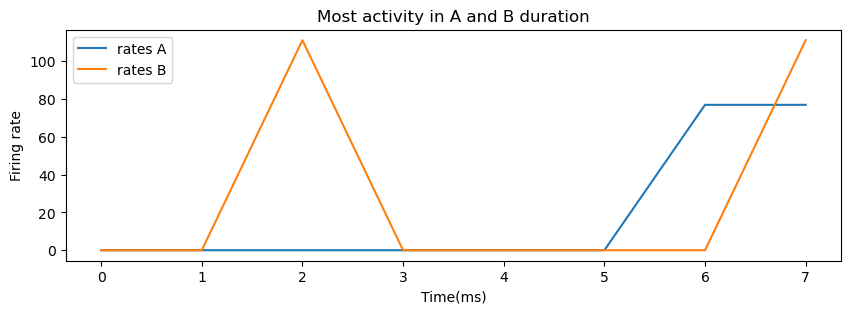

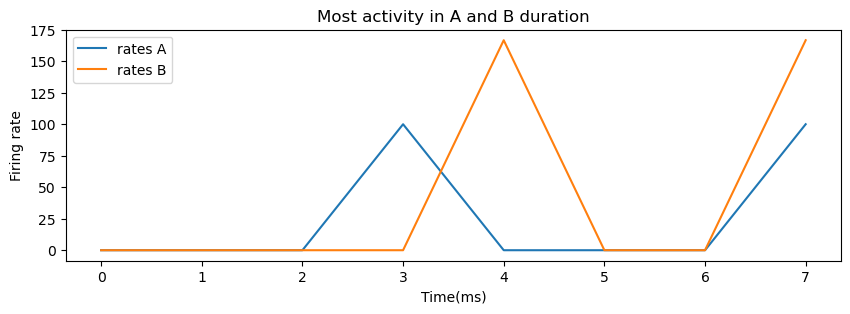

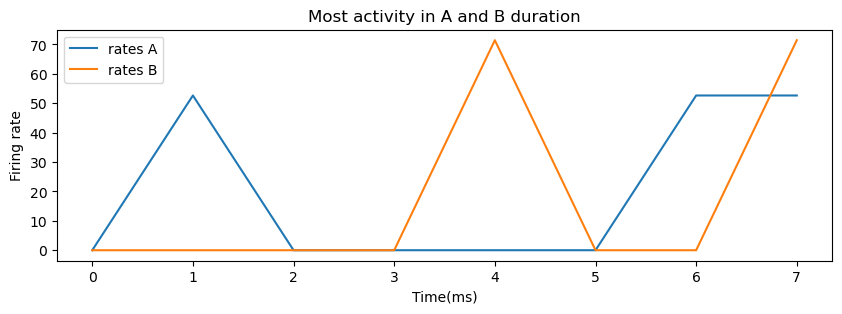

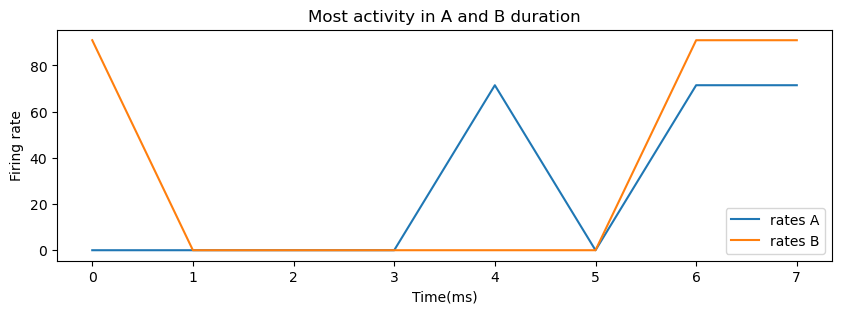

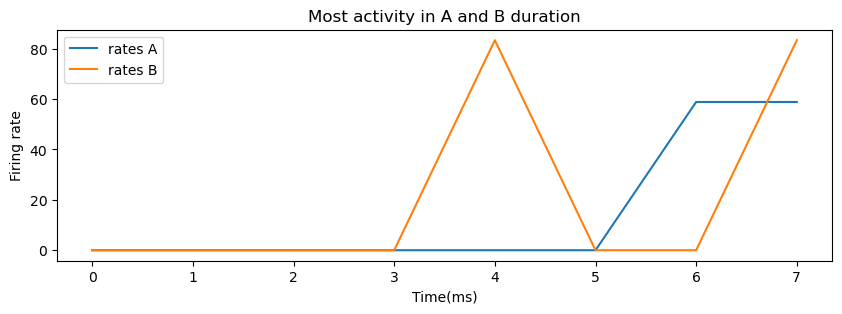

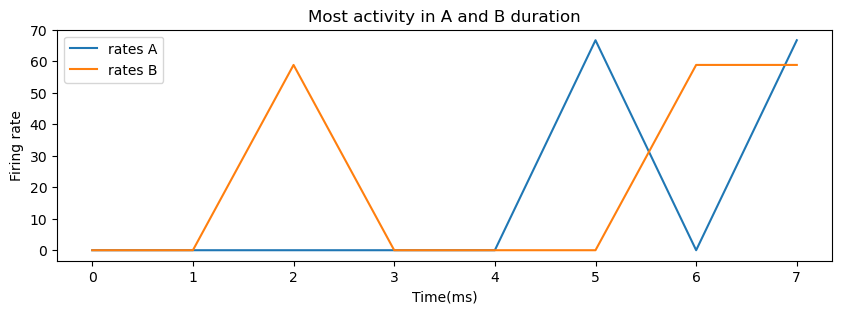

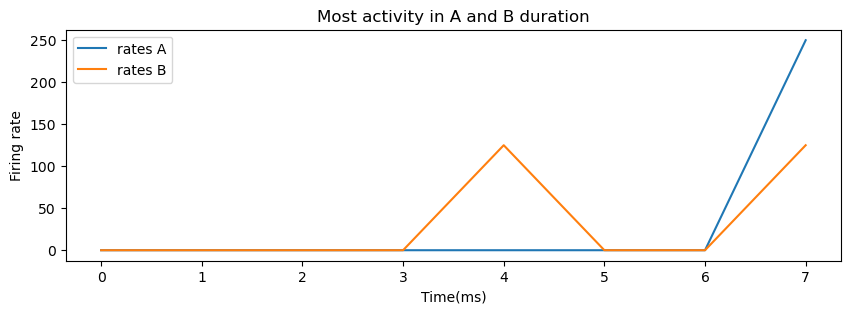

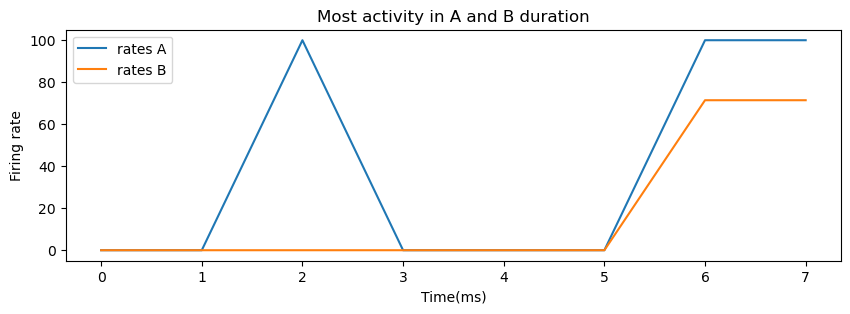

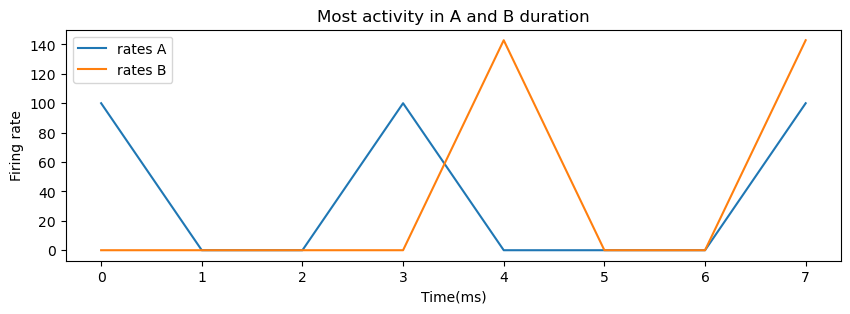

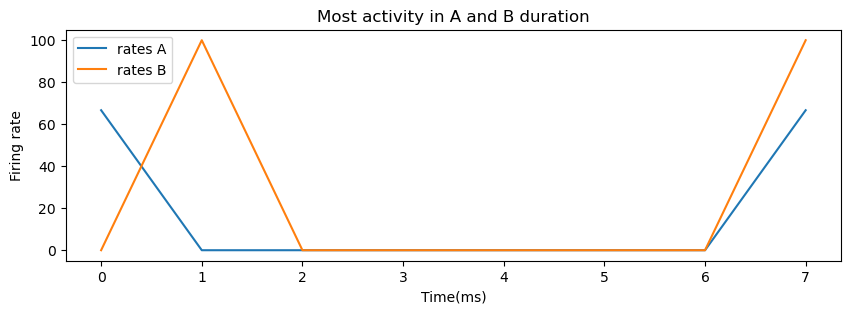

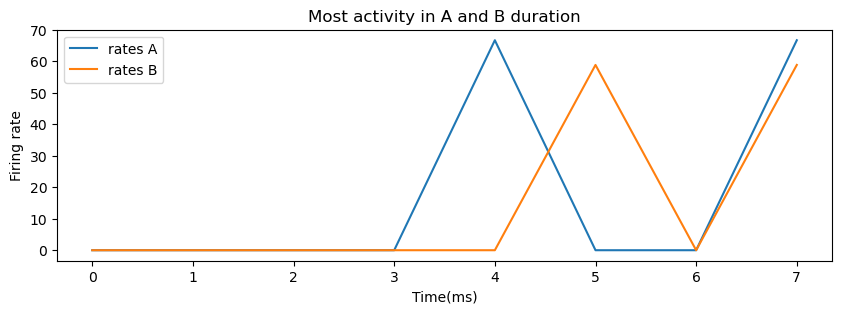

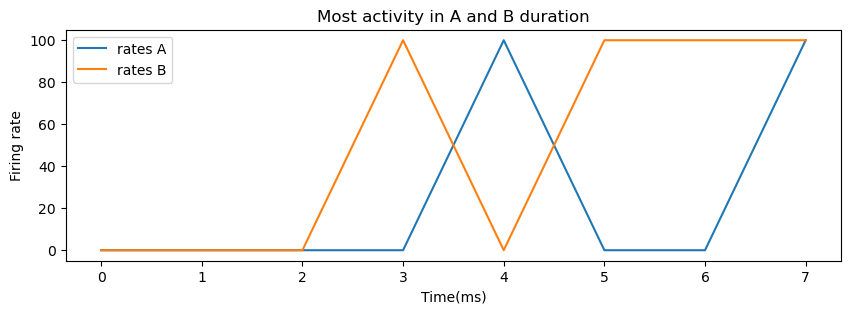

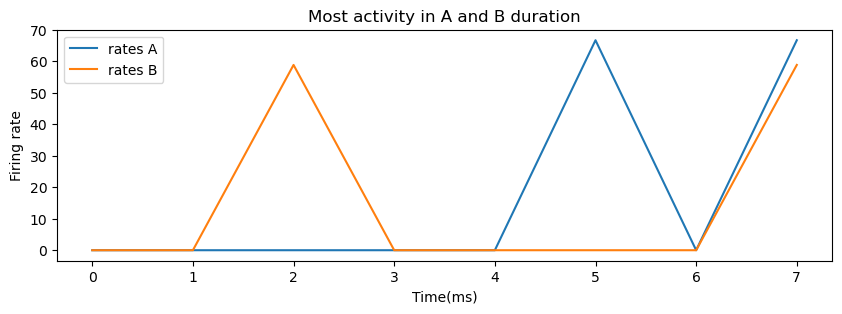

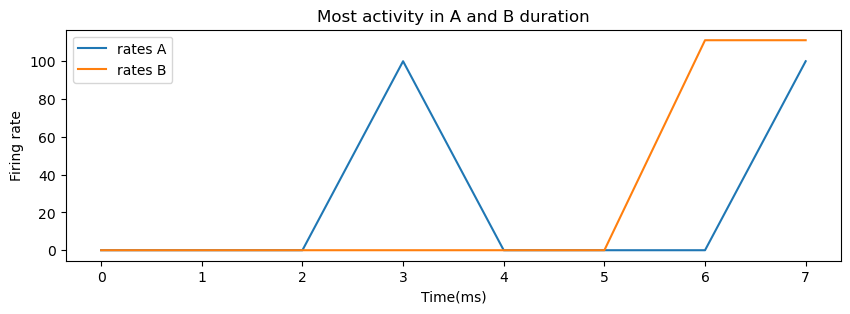

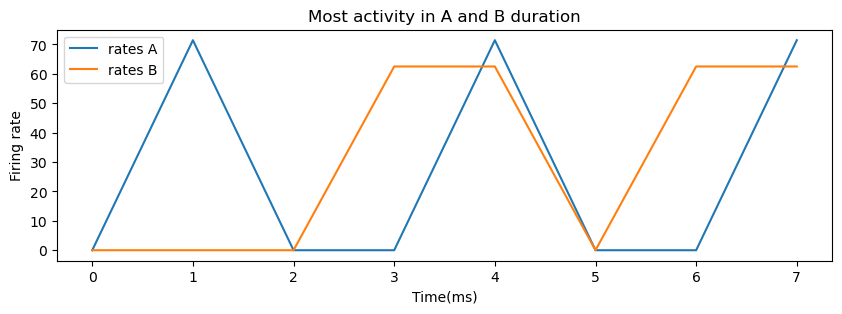

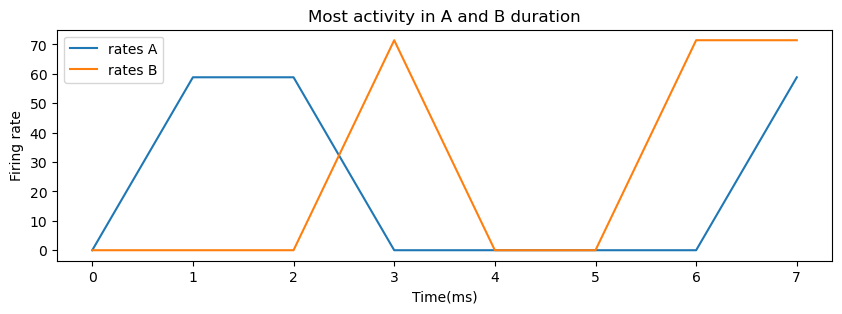

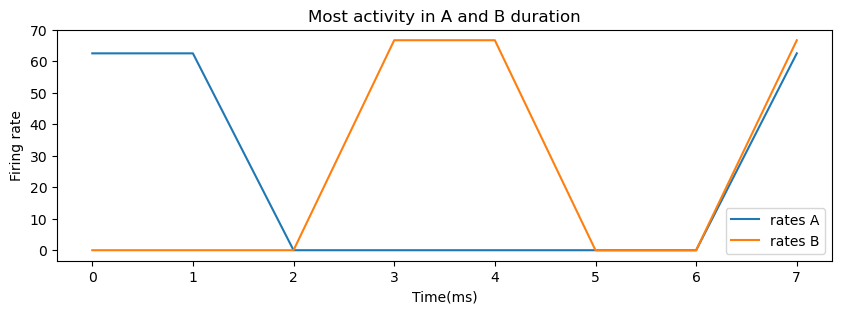

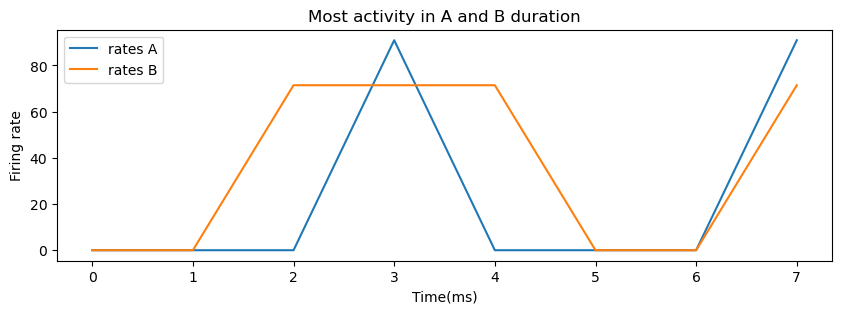

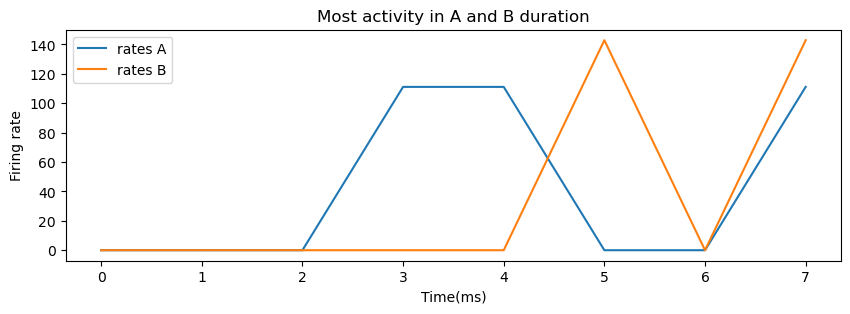

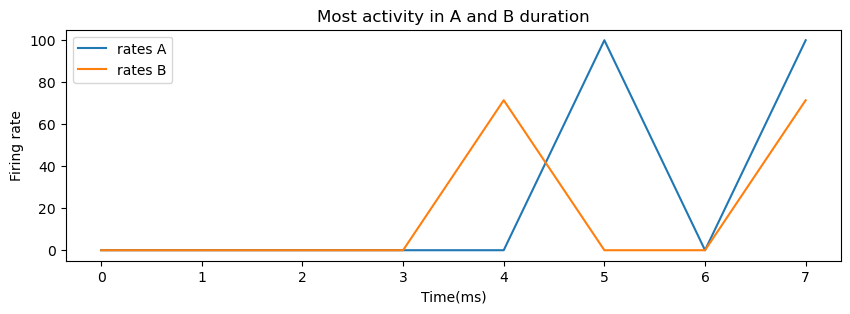

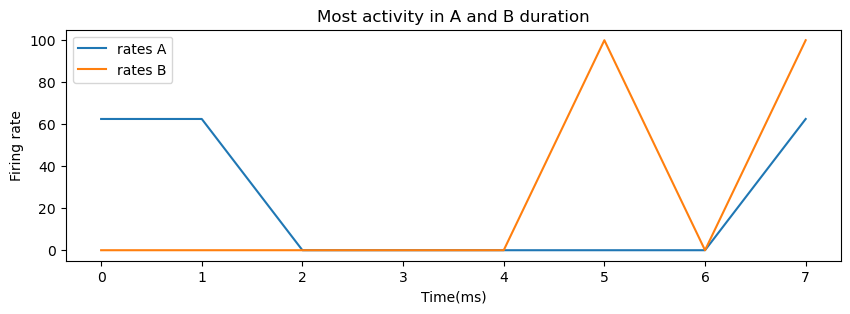

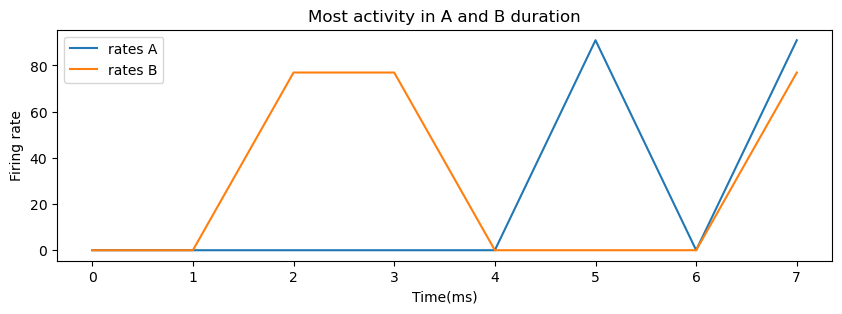

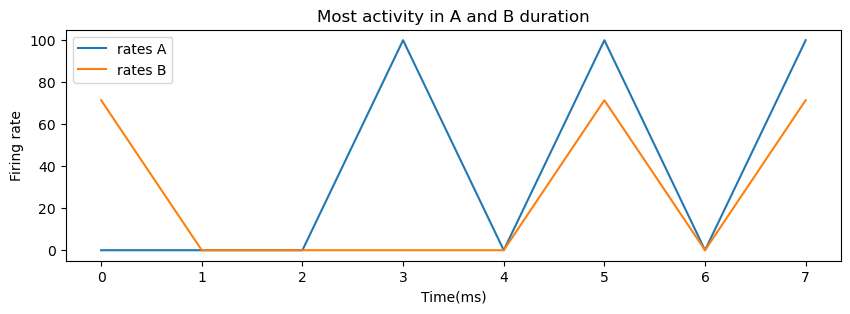

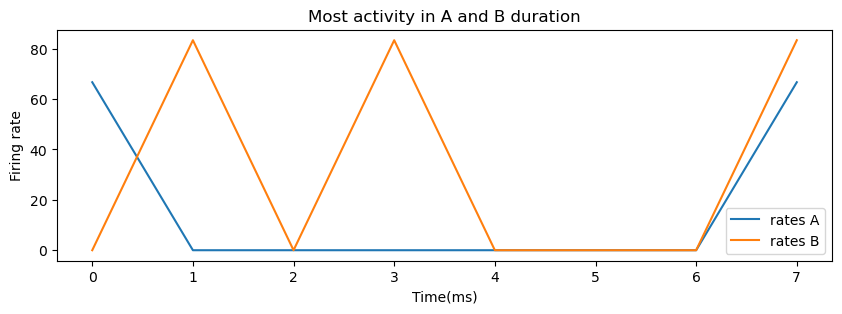

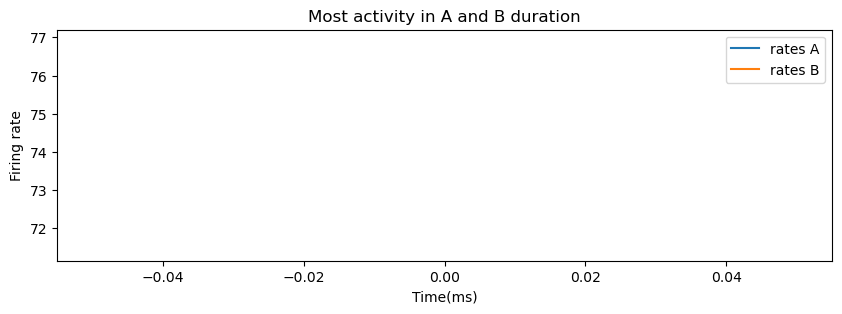

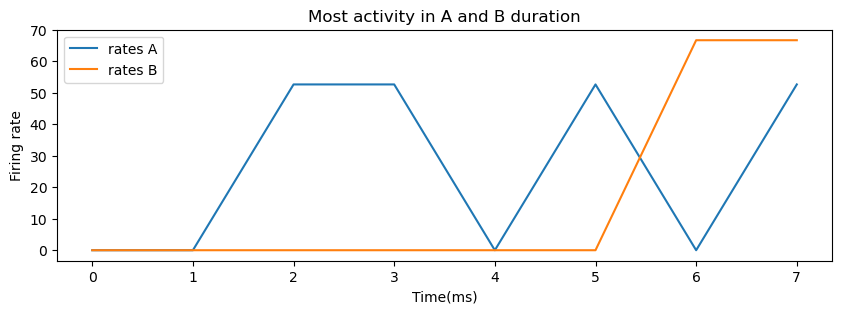

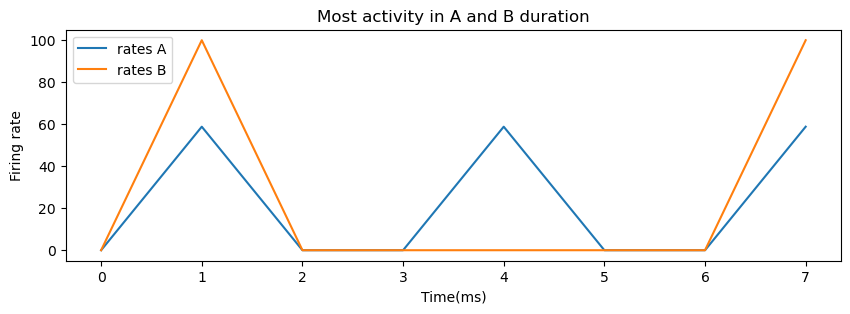

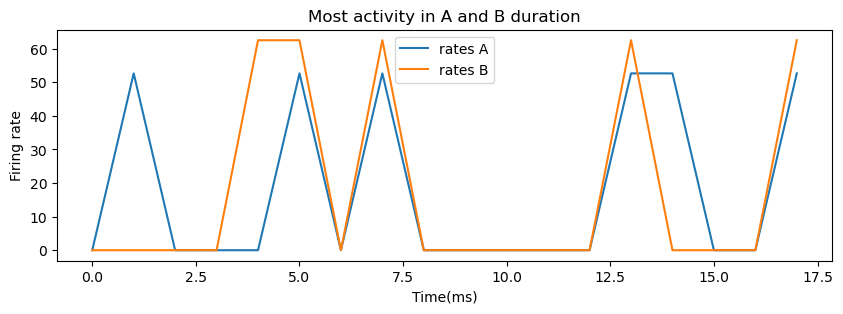

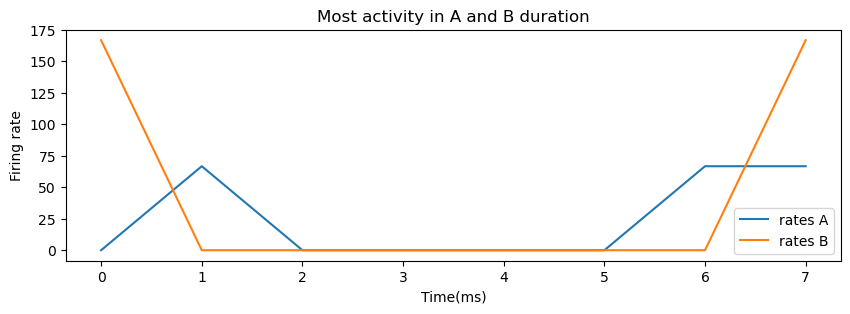

In [19]:
# calculate the measurement that I define 

A_2_B_measures = []
for i,s in enumerate(stimuli_time):
    (max_val_A, start_duration_act_A, rates_A) = find_max_fire(arr_mat1[i,50:-1])
    (min_val_A, end_duration_act_A) = find_min_fire(arr_mat1[i,50+start_duration_act_A:-1], start_duration_act_A)
    (max_val_B, start_duration_act_B, rates_B) = find_max_fire(arr_mat2[i,50:-1])
    (min_val_B, end_duration_act_B) = find_min_fire(arr_mat2[i,50+start_duration_act_B:-1], start_duration_act_B)
    
    # since we are looking from the activity starts and take index until it ends
    most_active_duration_A = end_duration_act_A
    most_active_duration_B = end_duration_act_B
    
    # Prague's Measurements ;D
    # strong excitation if close to 1
    SE_A_2_B = (most_active_duration_B+1) / (most_active_duration_A+1) # adding one avoiding divid by 0
    A_2_B_measures.append(SE_A_2_B)
    
    if SE_A_2_B == 1:
        fig,ax = plt.subplots(figsize=(10,3))
        ax.plot(arr_mat1[i,50+start_duration_act_A:50+start_duration_act_A+end_duration_act_A], label='rates A')
        ax.plot(arr_mat2[i,50+start_duration_act_B:50+start_duration_act_B+end_duration_act_B], label='rates B')
        ax.set_xlabel('Time(ms)')
        ax.set_ylabel('Firing rate')
        ax.set_title('Most activity in A and B duration')
        ax.legend()
        
# print(A_2_B_measures)
# I do round and count all numbers between 0.5 to 1.5
round_list = [round(num) for num in A_2_B_measures]
print(round_list.count(1))
# If I want less strog duration fit I can count also between 0-2
print(sum(round_list.count(i) for i in [0,1,2])) 

## 2- GLM optimal kernel and STA

In [20]:
sta_mat = scipy.io.loadmat('STA.mat')
kernel_mat = scipy.io.loadmat('kernel.mat')

spike_train = sta_mat['spikeTrain'][0]
stim_sig = sta_mat['stimSig'][0]

In [21]:
# I want to align the stim_sig to the spike train and for each spike I need to take a window 
# of +/-500ms from the stimulus. 
# Then average between all the windows I got 

In [22]:
'''
This function convert the spike train to time event to know from 
where I need to take a window from the stimulus
'''
def train_to_time(spike_train):
    spike_time = [i for i, x in enumerate(spike_train) if x == 1]
    return spike_time

In [23]:
'''
This function creates the +/-500ms window in the stimulus
returns a list of all the windows
'''
def create_windows(stimulus, spike_time, window_size):
    
    list_windows = []
    
    for t in spike_time:
        if t-window_size > 0 and t+window_size < len(stimulus):
            temp_wind = stimulus[t-window_size : t+window_size].tolist()
            list_windows.append(temp_wind)
        
    return list_windows

1000


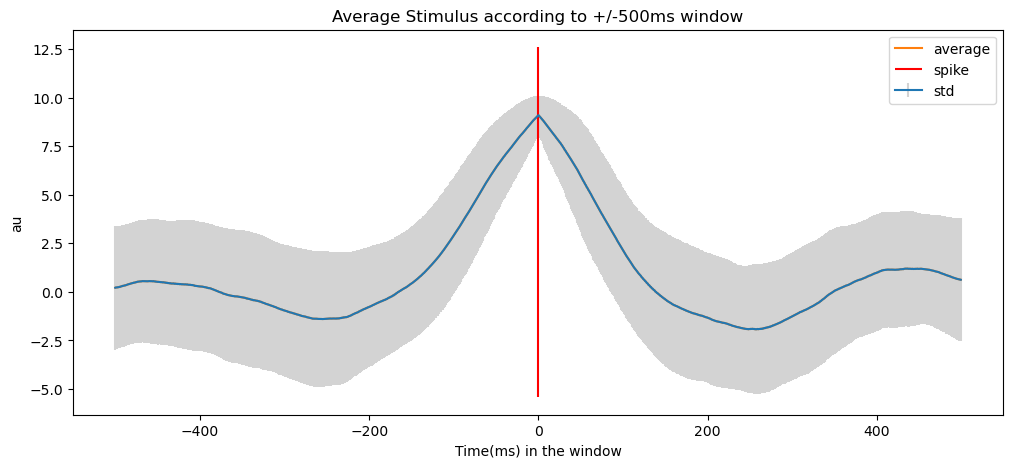

In [24]:
window_size = 500
spike_times = train_to_time(spike_train)
stim_window_list = np.array(create_windows(stim_sig, spike_times, window_size))

average_stim_wind = np.mean(stim_window_list,axis=0)
std_stim_wind = np.std(stim_window_list,axis=0)
max_std = np.max(std_stim_wind)
print(len(average_stim_wind))
fig,ax = plt.subplots(figsize=(12,5))
ax.errorbar(np.arange(-500,500),average_stim_wind,yerr=std_stim_wind,ecolor='lightgray', label='std')
ax.plot(np.arange(-500,500),average_stim_wind, label='average')
ax.vlines(0, np.min(average_stim_wind)-max_std,np.max(average_stim_wind)+max_std,color='r',label='spike')
ax.set_title('Average Stimulus according to +/-500ms window')
ax.set_xlabel('Time(ms) in the window')
ax.set_ylabel('au')
ax.legend()

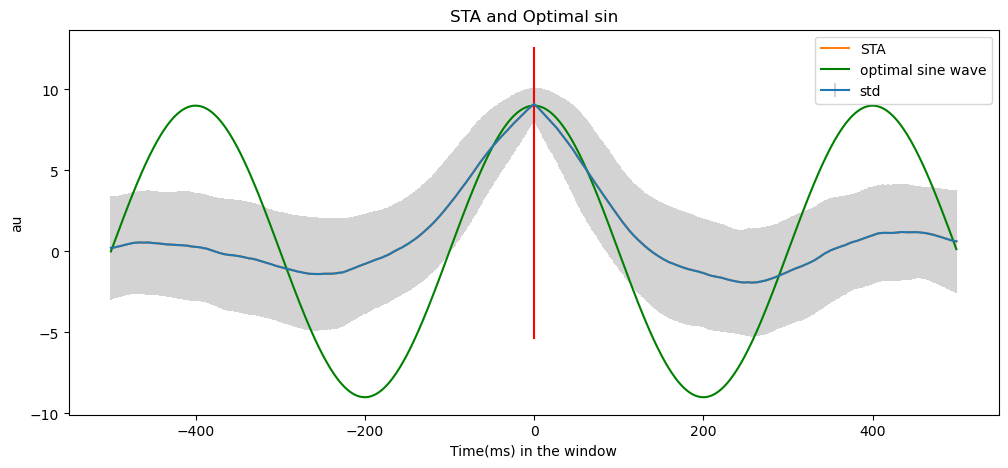

In [25]:
# finding the optimal sine wave according to the plot
# we can see that around -300ms to 0 it gets from the lowest point to the highest point
# this means freaquency of 5Hzaround the 0 
duration = np.arange(-500,500)
frequency = 2.5 # divided the 1s to time around 300ms to get the closest value to the original
sin_wave = np.sin(2*np.pi*frequency*np.arange(0,1,0.001))
fig,ax = plt.subplots(figsize=(12,5))
ax.errorbar(np.arange(-500,500),average_stim_wind,yerr=std_stim_wind,ecolor='lightgray', label='std')
ax.plot(np.arange(-500,500),average_stim_wind, label='STA')
ax.plot(duration,sin_wave*9,color='green',label="optimal sine wave")
ax.vlines(0, np.min(average_stim_wind)-max_std,np.max(average_stim_wind)+max_std,color='r')
ax.set_title('STA and Optimal sin')
ax.set_xlabel('Time(ms) in the window')
ax.set_ylabel('au')
ax.legend()

In [26]:
resp = kernel_mat['resp']
stim_noise = kernel_mat['stim'][0]

In [27]:
'''
This function gets a matrix of neuron response and a window size
It calculate the firing rate for each trial according to the window 
It return the mean firing rate list for all the different trials together
'''
def calculate_fr_according_wind_size(response_mat, window_size):
    num_trials = len(response_mat)
    means_rate_list_trails = []
    len_of_trial = len(response_mat[0])
    num_windows_in_trial = len_of_trial/window_size
    for t in range(num_trials):
        list_rates_in_trial = []
        for i in range(len_of_trial-window_size):
            wind_rate = response_mat[t, i : (i + window_size)]
            list_rates_in_trial.append(np.sum(wind_rate)/window_size)
        means_rate_list_trails.append(list_rates_in_trial)
    return means_rate_list_trails

In [28]:
'''
This function help us to decide what window size is optimal to calculate the firing rate.
We are looking on the firing rate with all the different windows and 
look for the window with the lowest std for the realibility.
'''
def find_optimal_window(response_mat, window_sizes_list):
    fr_stds_list = []
    for wind in window_sizes_list:
        temp_fr = calculate_fr_according_wind_size(response_mat, wind)
        print('mean fire rate= ', np.mean(temp_fr))
        fr_stds_list.append(np.std(temp_fr))
    print(fr_stds_list)
    min_std_fr = np.min(fr_stds_list)
    min_std_fr_index = np.argmin(fr_stds_list)
    optimal_wind = window_sizes_list[min_std_fr_index]
    return optimal_wind

In [29]:
window_sizes = [100,300,700,1000,1300]
optimal_wind = find_optimal_window(resp,window_sizes)
optimal_wind

mean fire rate=  0.032850273789649435
mean fire rate=  0.032847571747626994
mean fire rate=  0.03285811732112747
mean fire rate=  0.03285152067796611
mean fire rate=  0.03285997759140346
[0.022953525945863078, 0.013371742512002472, 0.00877164048438386, 0.007345659711883799, 0.006425268456866376]


1300

In [30]:
def calc_fr_r0(response_mat, window_size):
    num_trials = len(response_mat)
    len_of_trial = len(response_mat[0])
    num_windows_in_trial = len_of_trial/window_size
    baseline_mat = np.zeros([num_trials,len_of_trial-window_size])
    baseline = []
    for t in range(num_trials):
        list_rates_in_trial = []
        for i in range(len_of_trial-window_size):
            wind_rate = response_mat[t, i : (i + window_size)]
            list_rates_in_trial.append(np.sum(wind_rate)/window_size)
        baseline_mat[t] = list_rates_in_trial 
    baseline = np.mean(baseline_mat,axis=0)  
    return baseline

0.03285997759140349


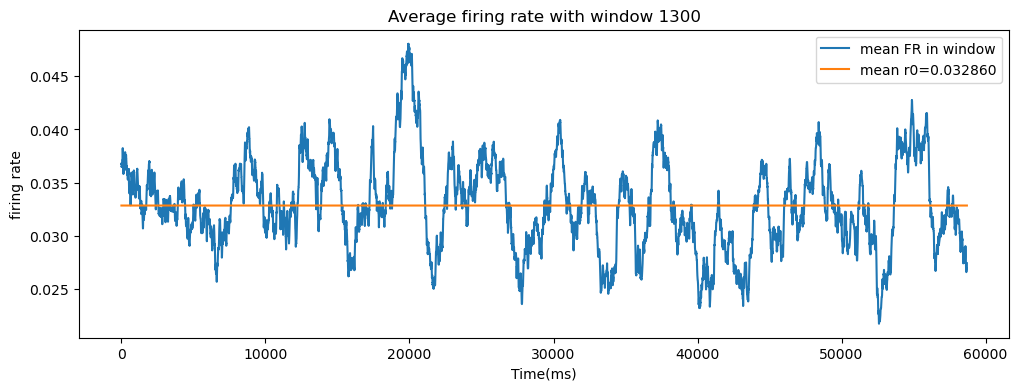

In [31]:
r0 = calc_fr_r0(resp,optimal_wind)
mean_r0 = np.mean(r0)
print(mean_r0)
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(r0, label='mean FR in window')
ax.plot(np.arange(0,len(r0)),np.ones(len(r0))*mean_r0, label='mean r0=%f'%mean_r0)
ax.set_title('Average firing rate with window %d'%optimal_wind)
ax.set_xlabel('Time(ms)')
ax.set_ylabel('firing rate')
ax.legend()

In [32]:
# calculating the optimal kernel (D) using the formula: D = (mean(noise) * STA) / var(noise)
# We need the neuron for calculate the STA. 
# We align the noise stimulus to the nueron activiy to find the average stimulus

'''
This function calculate the average stimulation according to the neuron responde in all trials 
It return the mean and the std of the STA of the noise
'''
def calculate_sta(responds_mat, stimulus, window_size):
    
    num_trials = len(responds_mat)
    list_of_wind_all_trials = []
    means_list = []
    stds_list = []
    average = 0
    for t in range(num_trials):
        spike_time = train_to_time(responds_mat[t])
        list_wind = create_windows(stimulus, spike_time, window_size)
        temp_mean_trial = np.mean(list_wind, axis=0)
        means_list.append(temp_mean_trial)
        temp_std_trial = np.std(list_wind,axis=0)
        stds_list.append(temp_std_trial)

    average = np.mean(means_list, axis=0)
    std = np.mean(stds_list, axis=0)
    return average, std


In [33]:
sta_noise_average, sta_noise_std = calculate_sta(resp,stim_noise,int(optimal_wind/2))
sta_noise_average, sta_noise_std

(array([-8.06747849e-04, -6.24284980e-04,  1.83133255e-05, ...,
         1.24058928e-03,  1.28880086e-03,  1.26934594e-03]),
 array([0.28930615, 0.28935378, 0.2904997 , ..., 0.29045667, 0.2906162 ,
        0.29045642]))

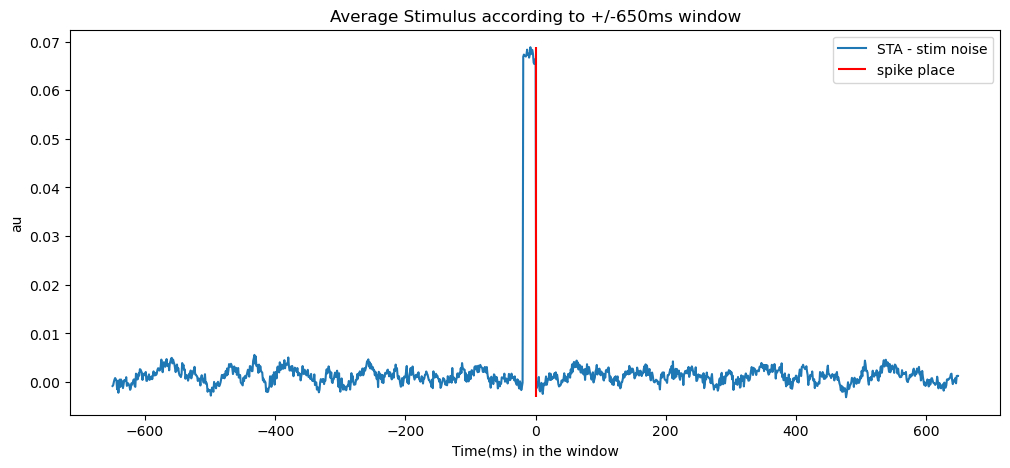

In [34]:
max_std = np.max(sta_noise_std)
fig,ax = plt.subplots(figsize=(12,5))
ax.plot(np.arange(-int(optimal_wind/2),int(optimal_wind/2)),sta_noise_average, label='STA - stim noise')
ax.vlines(0, np.min(sta_noise_average),np.max(sta_noise_average),color='r', label='spike place')
ax.set_title('Average Stimulus according to +/-650ms window')
ax.set_xlabel('Time(ms) in the window')
ax.set_ylabel('au')
ax.legend()

Text(0, 0.5, 'Firing rate')

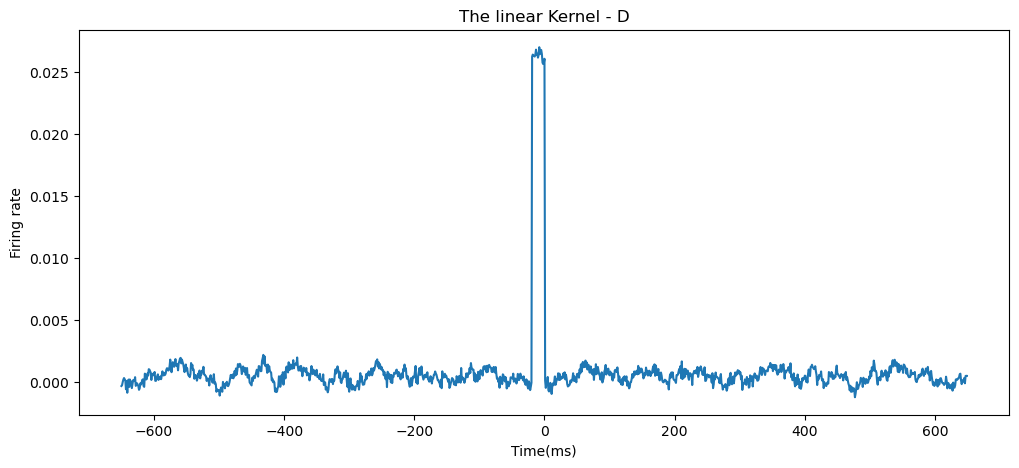

In [35]:
# fill in the kernel according to the formula: D(t)= ((noise_mean)*STA(t))/noise_var
mean_fr_noise  = np.mean(stim_noise)
var_fr_noise = np.var(stim_noise)
D = []
for i in sta_noise_average:
    D_t = (mean_r0 * i) / var_fr_noise
    D.append(D_t)

# ploting D
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(np.arange(-650,650), D)
ax.set_title('The linear Kernel - D')
ax.set_xlabel('Time(ms)')
ax.set_ylabel('Firing rate')

## Submition code for 2-C

In [111]:
# calculate the windows to the modal
r_modal = mean_r0+np.convolve(stim_noise,D)
baseline_modal = []
for i in range(int(len(r_modal)-optimal_wind)):
    wind_rate = r_modal[i : (i+ optimal_wind)]
    baseline_modal.append(np.sum(wind_rate)/optimal_wind)


Text(0, 0.5, 'firing rate')

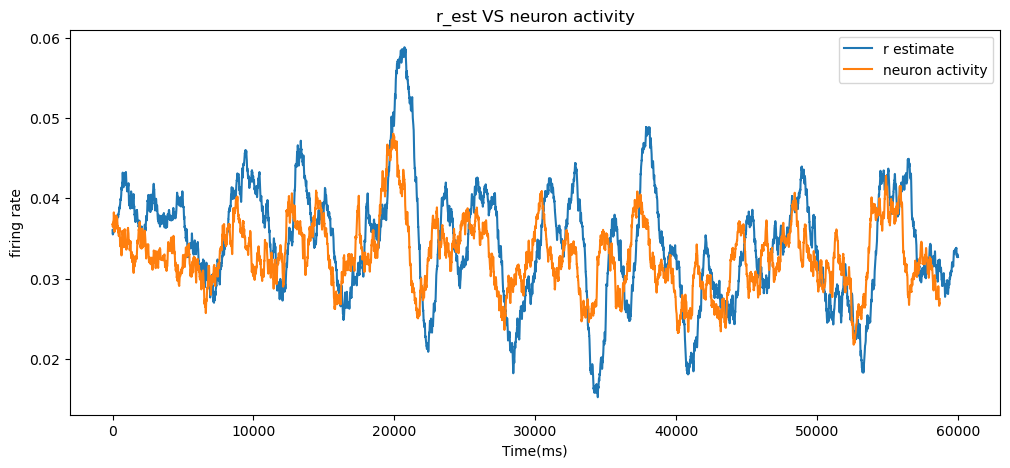

In [112]:
# plotting the modal and the neunral activity
fig,ax = plt.subplots(figsize=(12,5))
ax.plot(baseline_modal, label='r estimate')
ax.plot(r0, label='neuron activity')
ax.legend()
ax.set_title('r_est VS neuron activity')
ax.set_xlabel('Time(ms)')
ax.set_ylabel('firing rate')

In [113]:
# Calculate the Root Mean Square Error
sum_sqr = 0
for i in range(len(r0)):
    sqr = np.power(baseline_modal[i]-r0[i],2)
    sum_sqr = sum_sqr + sqr
rmse = np.sqrt(sum_sqr/len(r0))
rmse

0.0064592562380505454

In [126]:
L = np.convolve(stim_noise,D)
threshold = np.zeros(len(L))
F =[]
for thres,val in zip(threshold,L):
    F.append(np.maximum(thres,val))
    
r_modal_rectifier = mean_r0+F
baseline_modal_rectifier = []
for i in range(int(len(r_modal_rectifier)-optimal_wind)):
    wind_rate = r_modal_rectifier[i : (i+ optimal_wind)]
    baseline_modal_rectifier.append(np.sum(wind_rate)/optimal_wind)


Text(0, 0.5, 'firing rate')

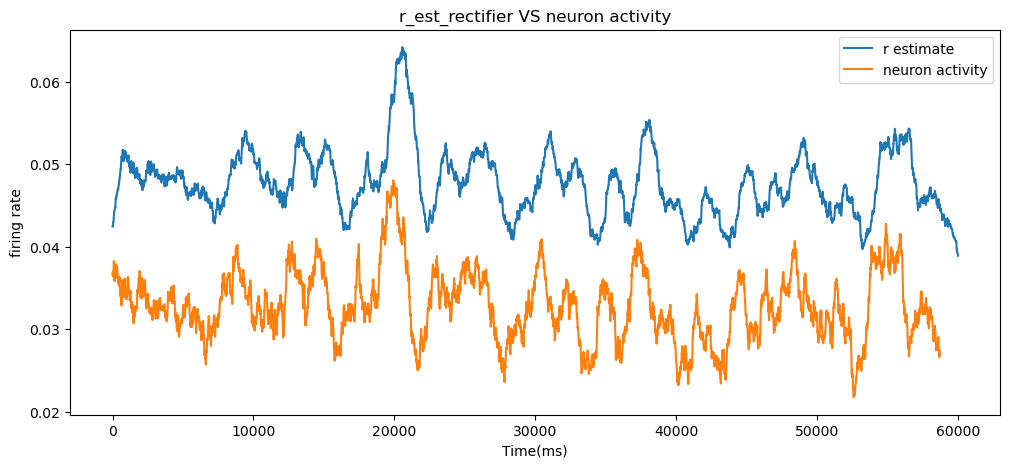

In [127]:
# plotting the modal and the neunral activity
fig,ax = plt.subplots(figsize=(12,5))
ax.plot(baseline_modal_rectifier, label='r estimate')
ax.plot(r0, label='neuron activity')
ax.legend()
ax.set_title('r_est_rectifier VS neuron activity')
ax.set_xlabel('Time(ms)')
ax.set_ylabel('firing rate')

In [128]:
# Calculate the Root Mean Square Error
sum_sqr = 0
for i in range(len(r0)):
    sqr = np.power(baseline_modal_rectifier[i]-r0[i],2)
    sum_sqr = sum_sqr + sqr
rmse = np.sqrt(sum_sqr/len(r0))
rmse

0.015446707154135424

In [129]:
L = np.convolve(stim_noise,D)
threshold = np.zeros(len(L))
F =[]
for thres,val in zip(threshold,L):
    F.append(np.maximum(thres,val))
    
r_modal_rectifier = mean_r0+F-0.013
baseline_modal_rectifier = []
for i in range(int(len(r_modal_rectifier)-optimal_wind)):
    wind_rate = r_modal_rectifier[i : (i+ optimal_wind)]
    baseline_modal_rectifier.append(np.sum(wind_rate)/optimal_wind)


Text(0, 0.5, 'firing rate')

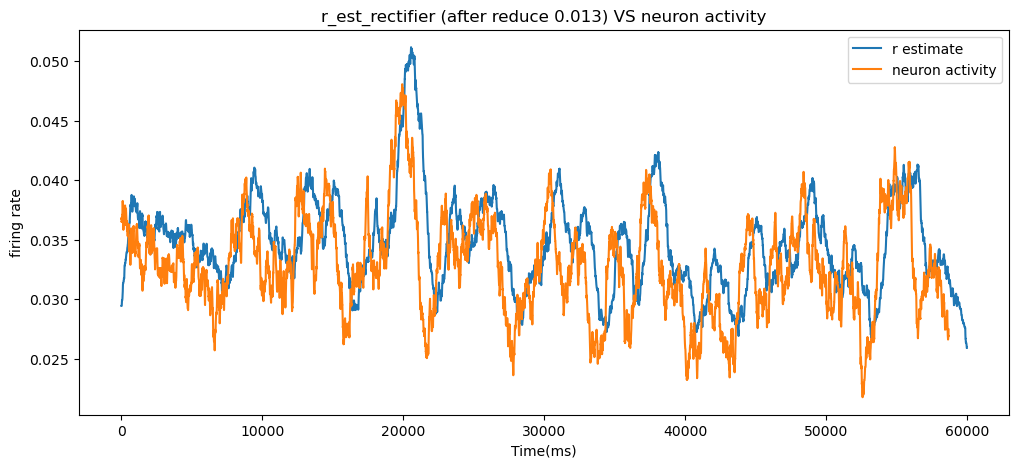

In [132]:
# plotting the modal and the neunral activity
fig,ax = plt.subplots(figsize=(12,5))
ax.plot(baseline_modal_rectifier, label='r estimate')
ax.plot(r0, label='neuron activity')
ax.legend()
ax.set_title('r_est_rectifier (after reduce 0.013) VS neuron activity')
ax.set_xlabel('Time(ms)')
ax.set_ylabel('firing rate')

In [131]:
# Calculate the Root Mean Square Error
sum_sqr = 0
for i in range(len(r0)):
    sqr = np.power(baseline_modal_rectifier[i]-r0[i],2)
    sum_sqr = sum_sqr + sqr
rmse = np.sqrt(sum_sqr/len(r0))
rmse

0.0044400425965897255

In [117]:
L = np.convolve(stim_noise,D)
threshold = np.zeros(len(L))
L_half = L[int(len(L)/2)]

F =[]
for thres,val in zip(threshold,L):
    sig = val / (1+math.exp(L_half-val))
    F.append(sig)
    
r_modal_sig = mean_r0+F
baseline_modal_sig = []
for i in range(int(len(r_modal_sig)-optimal_wind)):
    wind_rate = r_modal_sig[i : (i+ optimal_wind)]
    baseline_modal_sig.append(np.sum(wind_rate)/optimal_wind)


Text(0, 0.5, 'firing rate')

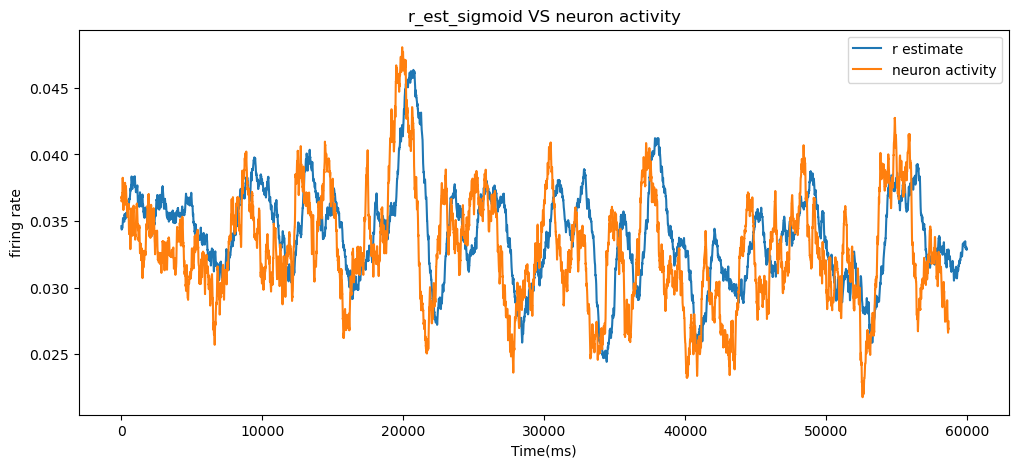

In [133]:
# plotting the modal and the neunral activity
fig,ax = plt.subplots(figsize=(12,5))
ax.plot(baseline_modal_sig, label='r estimate')
ax.plot(r0, label='neuron activity')
ax.legend()
ax.set_title('r_est_sigmoid VS neuron activity')
ax.set_xlabel('Time(ms)')
ax.set_ylabel('firing rate')

In [134]:
# Calculate the Root Mean Square Error
sum_sqr = 0
for i in range(len(r0)):
    sqr = np.power(baseline_modal_sig[i]-r0[i],2)
    sum_sqr = sum_sqr + sqr
rmse = np.sqrt(sum_sqr/len(r0))
rmse

0.0040701666820467716